In [2]:
%pip install sqlalchemy pyodbc matplotlib seaborn plotly

Note: you may need to restart the kernel to use updated packages.


In [1]:

import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Database connection configuration
# Replace with your actual credentials
server = 'upgrade-abnb-server.database.windows.net'
database = 'Upgrade_Abnb'
username = 'vmabnbserver'  # Replace with actual username
password = 'JWkWW8Bg%>jy,Xj!'  # Replace with actual password

# Function to test ODBC drivers and create connection
def create_db_connection():
    """Create database connection with fallback driver options"""
    drivers = [
        'ODBC Driver 18 for SQL Server',
        'ODBC Driver 17 for SQL Server',
        'ODBC Driver 13 for SQL Server',
        'SQL Server Native Client 11.0',
        'SQL Server'
    ]
    
    # Test available drivers
    available_drivers = [driver for driver in pyodbc.drivers() if any(d in driver for d in ['SQL Server', 'ODBC'])]
    print(f"Available ODBC drivers: {available_drivers}")
    
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes&Encrypt=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver: {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver}: {str(e)}")
                continue
    
    # If all drivers fail, try without encryption
    for driver in drivers:
        if driver in available_drivers:
            try:
                connection_string = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}&TrustServerCertificate=yes'
                engine = create_engine(connection_string)
                # Test connection
                with engine.connect() as conn:
                    conn.execute(sqlalchemy.text("SELECT 1"))
                print(f"Successfully connected using driver (no encryption): {driver}")
                return engine, connection_string
            except Exception as e:
                print(f"Failed with driver {driver} (no encryption): {str(e)}")
                continue
    
    raise Exception("Could not establish database connection with any available driver")

# Create connection engine
engine, connection_string = create_db_connection()

# Function to execute queries and return DataFrames
def query_to_df(query, engine=engine):
    """Execute SQL query and return DataFrame"""
    return pd.read_sql(query, engine)

# Load main dataset
query = "SELECT * FROM [dbo].[listings_completo]"
df_listings = query_to_df(query)

# Configure matplotlib and seaborn for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Display basic information
print("=== DATABASE CONNECTION ESTABLISHED ===")
print(f"Connected to: {database}")
print(f"DataFrame shape: {df_listings.shape}")
print(f"Columns: {list(df_listings.columns)}")
print("\n=== FIRST 5 ROWS ===")
print(df_listings.head())
print("\n=== DATA TYPES ===")
print(df_listings.dtypes)
print("\n=== MISSING VALUES ===")
print(df_listings.isnull().sum())

Available ODBC drivers: ['SQL Server']
Successfully connected using driver: SQL Server
=== DATABASE CONNECTION ESTABLISHED ===
Connected to: Upgrade_Abnb
DataFrame shape: (1630091, 63)
Columns: ['listing_id', 'id_x', 'date', 'reviewer_id', 'reviewer_name', 'id_y', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'availability_eoy', 'number_of_reviews_ly', 'estimated_occupancy_l365d', 'estimated_revenue_l365d

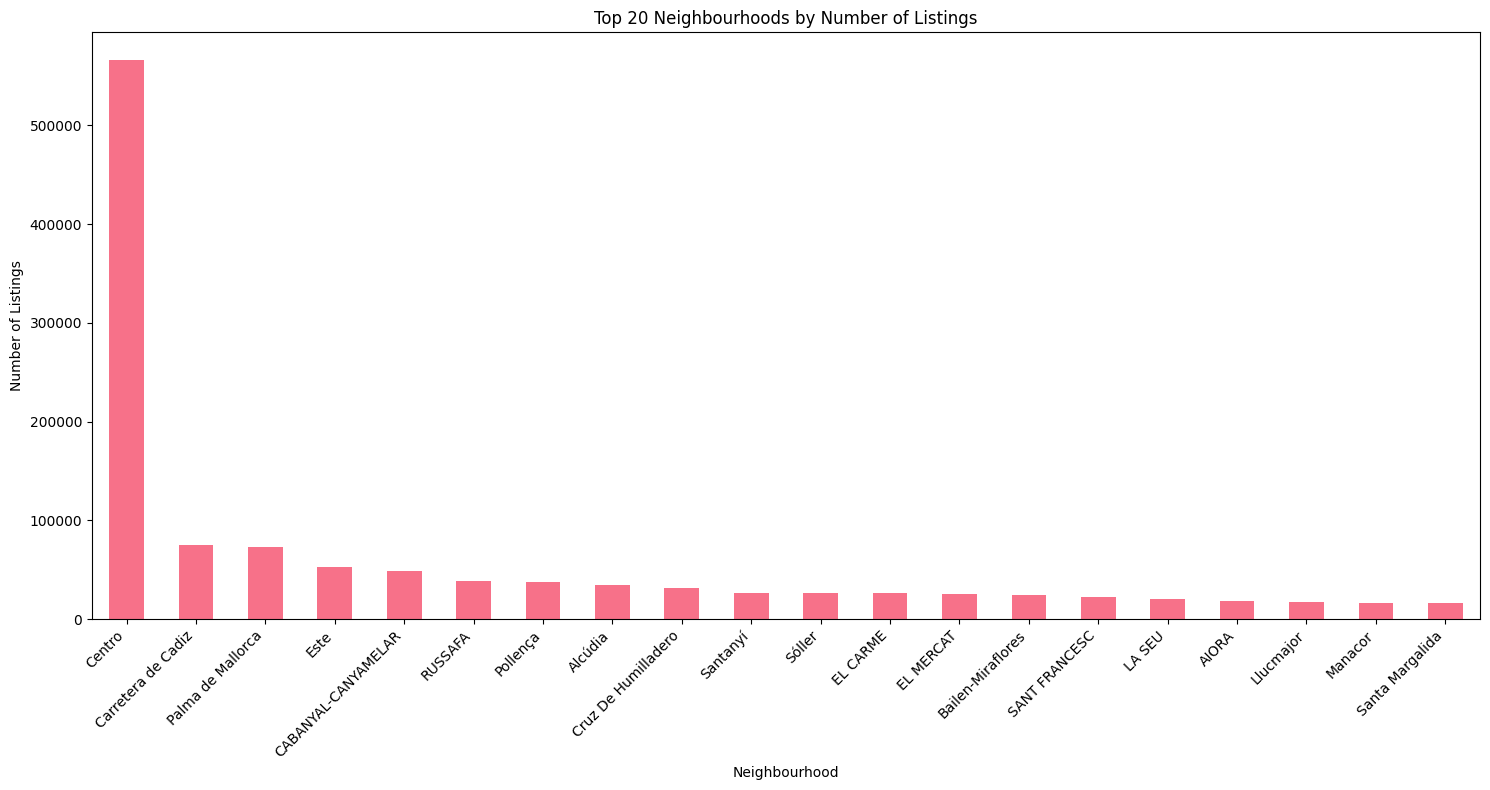

Top 10 Neighbourhoods by Listing Count:
neighbourhood_cleansed
Centro                 565835
Carretera de Cadiz      74791
Palma de Mallorca       72495
Este                    52327
CABANYAL-CANYAMELAR     48882
RUSSAFA                 38872
Pollença                37605
Alcúdia                 34677
Cruz De Humilladero     30914
Santanyí                26385
Name: count, dtype: int64


In [2]:
# Count listings by neighbourhood
neighbourhood_counts = df_listings['neighbourhood_cleansed'].value_counts()

# Create a bar plot
plt.figure(figsize=(15, 8))
neighbourhood_counts.head(20).plot(kind='bar')
plt.title('Top 20 Neighbourhoods by Number of Listings')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Listings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display the top 10 neighbourhoods with counts
print("Top 10 Neighbourhoods by Listing Count:")
print(neighbourhood_counts.head(10))

In [3]:
# Comprehensive statistical analysis of the listings dataset

print("=== COMPREHENSIVE DATASET STATISTICS ===\n")

# Basic dataset information
print("1. DATASET OVERVIEW")
print(f"Total number of records: {df_listings.shape[0]:,}")
print(f"Total number of columns: {df_listings.shape[1]}")
print(f"Memory usage: {df_listings.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Numerical columns statistics
print("\n2. NUMERICAL COLUMNS STATISTICS")
numerical_cols = df_listings.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print(df_listings[numerical_cols].describe())
else:
    print("No numerical columns found")

# Categorical columns statistics
print("\n3. CATEGORICAL COLUMNS STATISTICS")
categorical_cols = df_listings.select_dtypes(include=['object']).columns
for col in categorical_cols[:10]:  # Show first 10 categorical columns
    unique_count = df_listings[col].nunique()
    print(f"{col}: {unique_count} unique values")
    if unique_count <= 10:
        print(f"  Values: {df_listings[col].value_counts().head().to_dict()}")
    print()

# Missing values analysis
print("\n4. MISSING VALUES ANALYSIS")
missing_data = df_listings.isnull().sum()
missing_percent = (missing_data / len(df_listings)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percentage': missing_percent.values
}).sort_values('Missing Count', ascending=False)

print("Columns with missing values:")
print(missing_df[missing_df['Missing Count'] > 0].head(10))

# Data types distribution
print("\n5. DATA TYPES DISTRIBUTION")
dtype_counts = df_listings.dtypes.value_counts()
print(dtype_counts)

# If price column exists, show price statistics
if 'price' in df_listings.columns:
    print("\n6. PRICE ANALYSIS")
    try:
        # Try to convert price to numeric if it's string
        if df_listings['price'].dtype == 'object':
            price_clean = pd.to_numeric(df_listings['price'].str.replace('[\$,]', '', regex=True), errors='coerce')
        else:
            price_clean = df_listings['price']
        
        print(f"Price statistics:")
        print(price_clean.describe())
        print(f"Price range: ${price_clean.min():.2f} - ${price_clean.max():.2f}")
    except:
        print("Could not analyze price column")

print("\n=== ANALYSIS COMPLETE ===")

<>:53: SyntaxWarning: invalid escape sequence '\$'
<>:53: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\1145578963.py:53: SyntaxWarning: invalid escape sequence '\$'
  price_clean = pd.to_numeric(df_listings['price'].str.replace('[\$,]', '', regex=True), errors='coerce')


=== COMPREHENSIVE DATASET STATISTICS ===

1. DATASET OVERVIEW
Total number of records: 1,630,091
Total number of columns: 63
Memory usage: 3244.53 MB

2. NUMERICAL COLUMNS STATISTICS
       host_response_rate  host_acceptance_rate      latitude     longitude  \
count        1.630091e+06          1.630091e+06  1.630091e+06  1.630091e+06   
mean         9.587944e+01          9.456599e+01  3.821170e+01 -1.447125e+00   
std          1.767778e+01          1.584745e+01  1.417780e+00  3.064513e+00   
min          0.000000e+00          0.000000e+00  3.664754e+01 -4.582370e+00   
25%          1.000000e+02          9.700000e+01  3.672264e+01 -4.421890e+00   
50%          1.000000e+02          1.000000e+02  3.938091e+01 -3.871300e-01   
75%          1.000000e+02          1.000000e+02  3.947851e+01  2.448120e+00   
max          1.000000e+02          1.000000e+02  3.992914e+01  3.474510e+00   

       accommodates     bathrooms      bedrooms          beds         price  \
count  1.630091e+06  1.630

Gráfico(s) mostrando las características de las viviendas (habitaciones, camas, baños, accomodates, room type, property type, minimum and máximum nights, instant bookable)

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\623880999.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data for data in box_data if len(data) > 0], labels=range(1, len([data for data in box_data if len(data) > 0]) + 1))


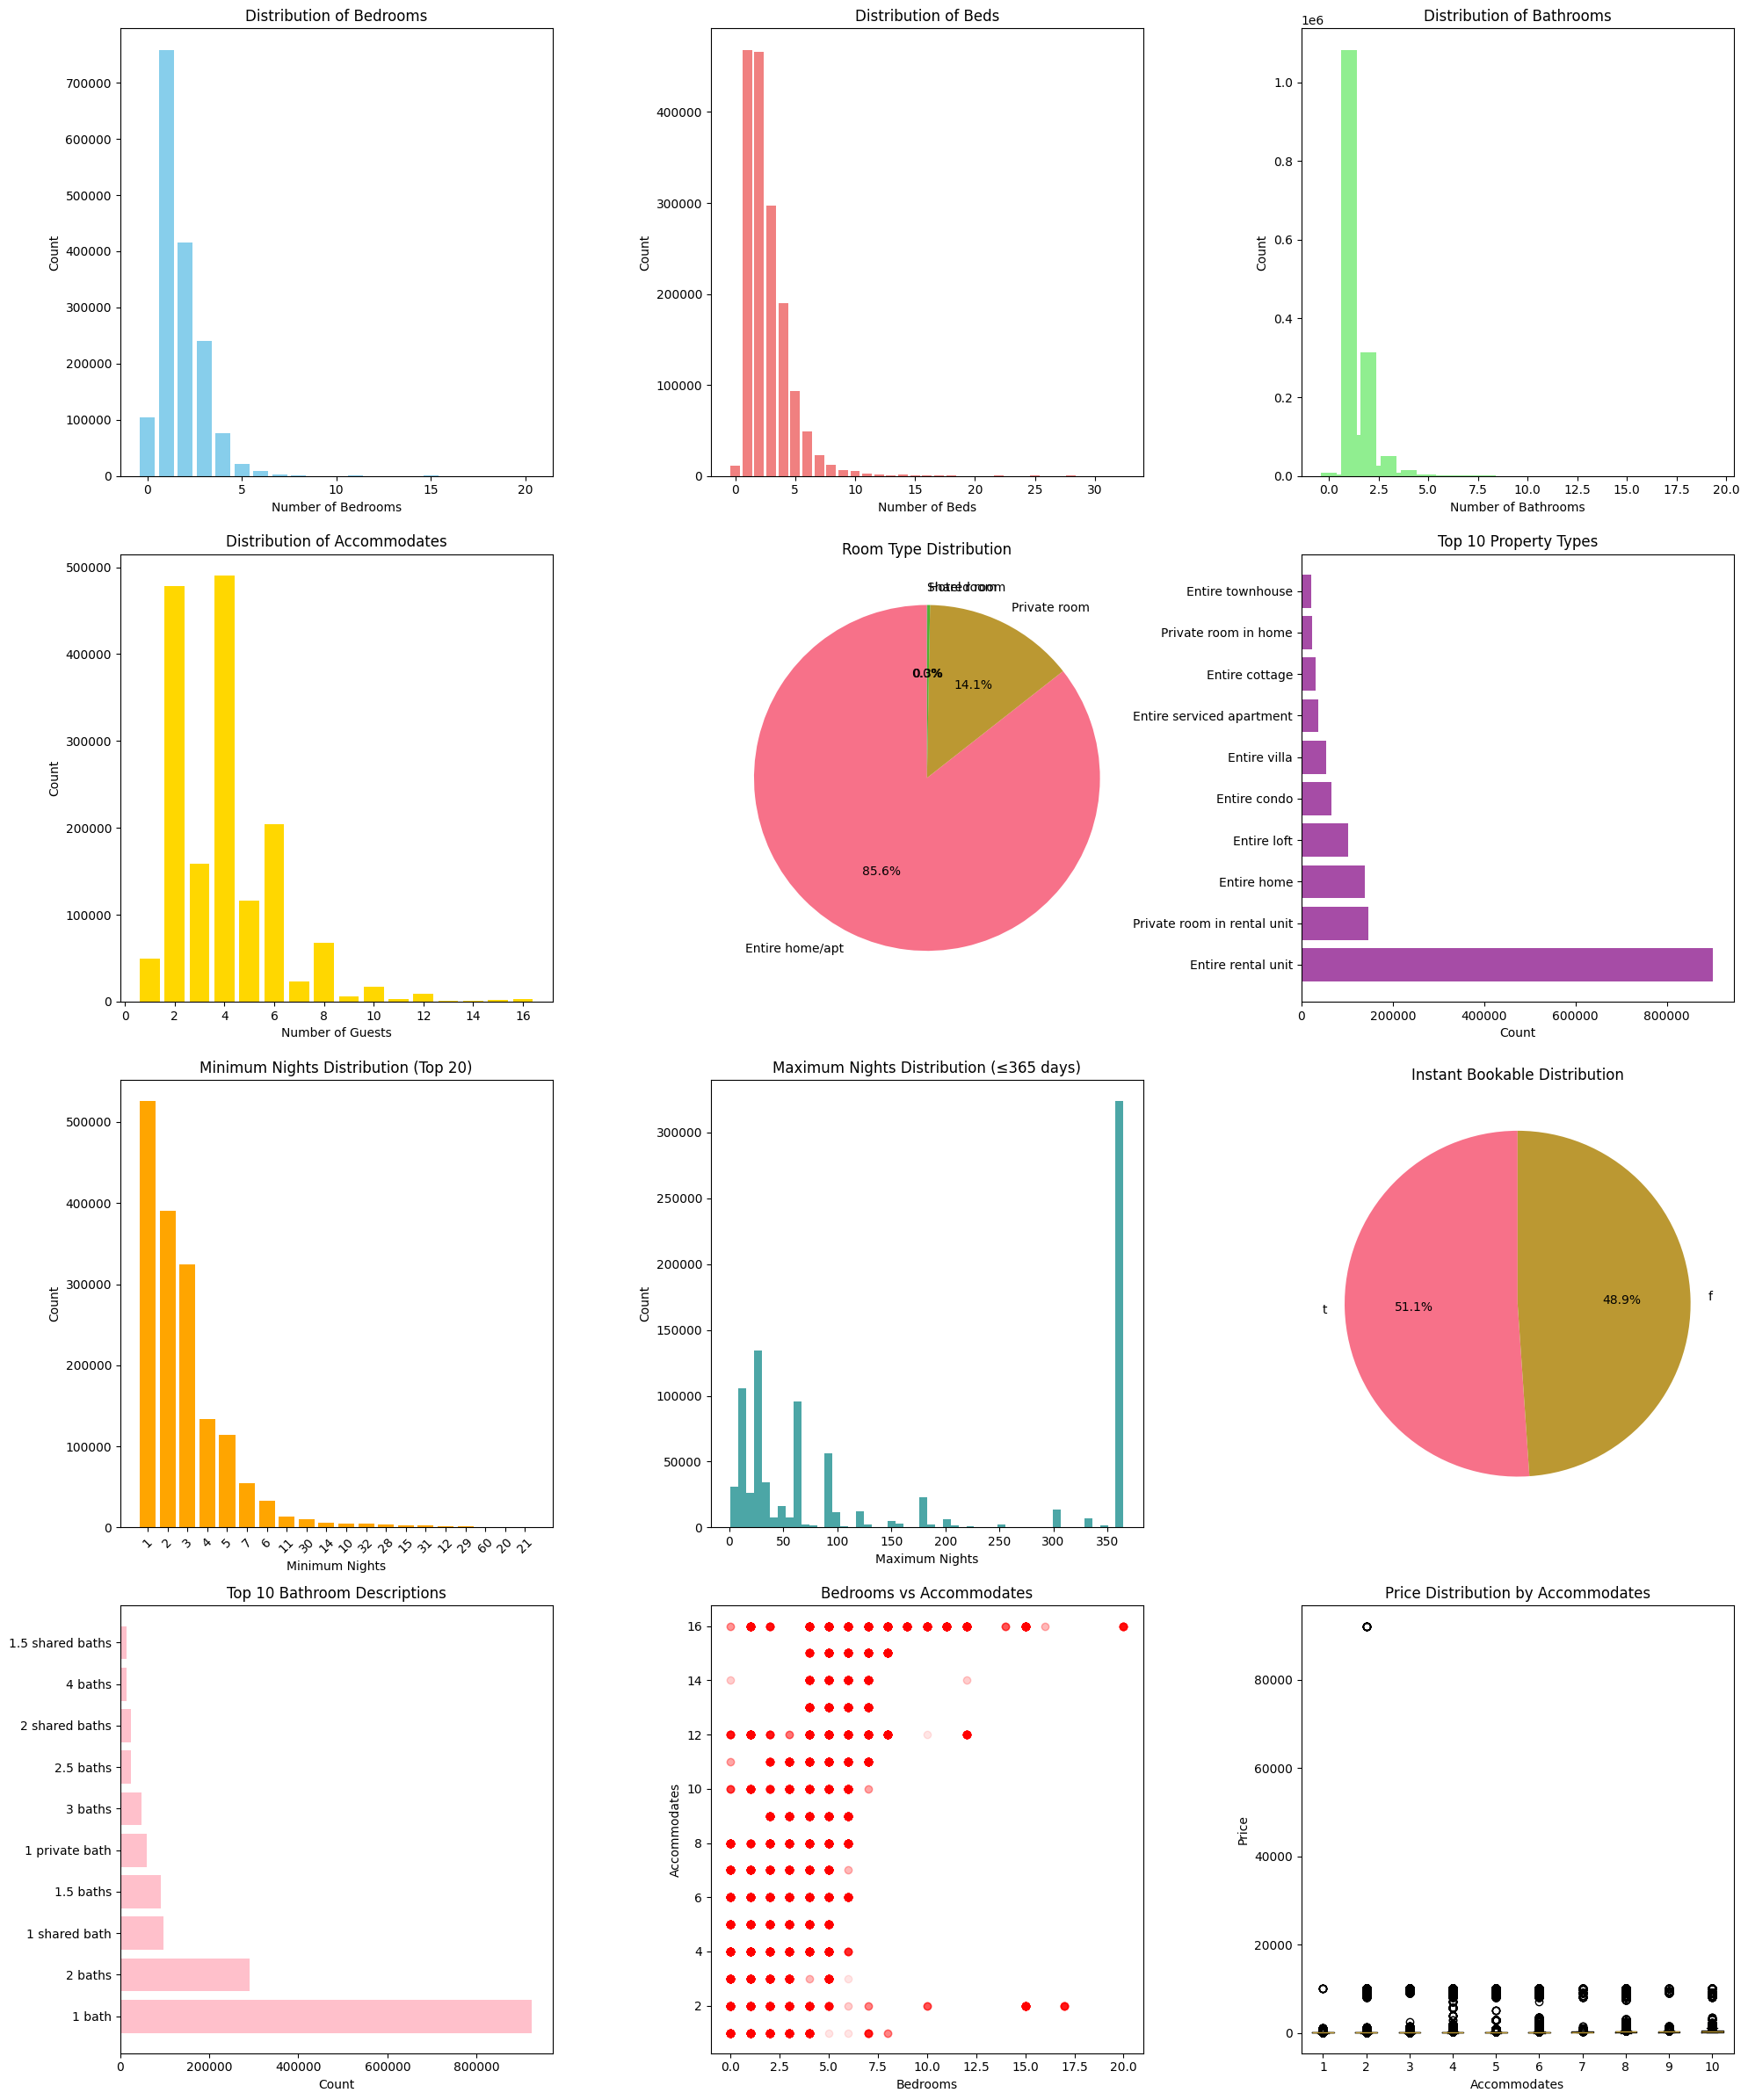

=== PROPERTY CHARACTERISTICS SUMMARY ===

1. BEDROOMS STATISTICS
Range: 0 - 20 bedrooms
Most common: 1 bedrooms (758,816 properties)
Average: 1.73 bedrooms

2. BEDS STATISTICS
Range: 0 - 32 beds
Most common: 1 beds (468,445 properties)
Average: 2.63 beds

3. BATHROOMS STATISTICS
Range: 0.0 - 19.0 bathrooms
Most common: 1.0 bathrooms (1,082,723 properties)
Average: 1.39 bathrooms

4. ACCOMMODATES STATISTICS
Range: 1 - 16 guests
Most common: 4 guests (490,472 properties)
Average: 3.94 guests

5. ROOM TYPE BREAKDOWN
Entire home/apt: 1,395,214 (85.6%)
Private room: 230,213 (14.1%)
Hotel room: 4,275 (0.3%)
Shared room: 389 (0.0%)

6. PROPERTY TYPE BREAKDOWN (Top 5)
Entire rental unit: 901,274 (55.3%)
Private room in rental unit: 146,947 (9.0%)
Entire home: 138,043 (8.5%)
Entire loft: 101,691 (6.2%)
Entire condo: 66,339 (4.1%)

7. INSTANT BOOKABLE BREAKDOWN
t: 832,777 (51.1%)
f: 797,314 (48.9%)

8. MINIMUM NIGHTS STATISTICS
Range: 1 - 400 nights
Most common: 1 nights (525,601 properties)
Ave

In [4]:
# Create comprehensive visualizations for property characteristics
fig = plt.figure(figsize=(20, 24))

# 1. Bedrooms distribution
plt.subplot(4, 3, 1)
bedroom_counts = df_listings['bedrooms'].value_counts().sort_index()
plt.bar(bedroom_counts.index, bedroom_counts.values, color='skyblue')
plt.title('Distribution of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')

# 2. Beds distribution
plt.subplot(4, 3, 2)
beds_counts = df_listings['beds'].value_counts().sort_index()
plt.bar(beds_counts.index, beds_counts.values, color='lightcoral')
plt.title('Distribution of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Count')

# 3. Bathrooms distribution
plt.subplot(4, 3, 3)
bathroom_counts = df_listings['bathrooms'].value_counts().sort_index()
plt.bar(bathroom_counts.index, bathroom_counts.values, color='lightgreen')
plt.title('Distribution of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Count')

# 4. Accommodates distribution
plt.subplot(4, 3, 4)
accommodates_counts = df_listings['accommodates'].value_counts().sort_index()
plt.bar(accommodates_counts.index, accommodates_counts.values, color='gold')
plt.title('Distribution of Accommodates')
plt.xlabel('Number of Guests')
plt.ylabel('Count')

# 5. Room type distribution
plt.subplot(4, 3, 5)
room_type_counts = df_listings['room_type'].value_counts()
plt.pie(room_type_counts.values, labels=room_type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Room Type Distribution')

# 6. Property type distribution (top 10)
plt.subplot(4, 3, 6)
property_type_counts = df_listings['property_type'].value_counts().head(10)
plt.barh(range(len(property_type_counts)), property_type_counts.values, color='purple', alpha=0.7)
plt.yticks(range(len(property_type_counts)), property_type_counts.index)
plt.title('Top 10 Property Types')
plt.xlabel('Count')

# 7. Minimum nights distribution
plt.subplot(4, 3, 7)
min_nights_counts = df_listings['minimum_nights'].value_counts().head(20)
plt.bar(range(len(min_nights_counts)), min_nights_counts.values, color='orange')
plt.title('Minimum Nights Distribution (Top 20)')
plt.xlabel('Minimum Nights')
plt.ylabel('Count')
plt.xticks(range(len(min_nights_counts)), min_nights_counts.index, rotation=45)

# 8. Maximum nights distribution (log scale for better visualization)
plt.subplot(4, 3, 8)
max_nights_filtered = df_listings[df_listings['maximum_nights'] <= 365]['maximum_nights']
plt.hist(max_nights_filtered, bins=50, color='teal', alpha=0.7)
plt.title('Maximum Nights Distribution (≤365 days)')
plt.xlabel('Maximum Nights')
plt.ylabel('Count')

# 9. Instant bookable distribution
plt.subplot(4, 3, 9)
instant_bookable_counts = df_listings['instant_bookable'].value_counts()
plt.pie(instant_bookable_counts.values, labels=instant_bookable_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Instant Bookable Distribution')

# 10. Bathrooms text analysis
plt.subplot(4, 3, 10)
bathrooms_text_counts = df_listings['bathrooms_text'].value_counts().head(10)
plt.barh(range(len(bathrooms_text_counts)), bathrooms_text_counts.values, color='pink')
plt.yticks(range(len(bathrooms_text_counts)), bathrooms_text_counts.index)
plt.title('Top 10 Bathroom Descriptions')
plt.xlabel('Count')

# 11. Accommodates vs Bedrooms scatter plot
plt.subplot(4, 3, 11)
plt.scatter(df_listings['bedrooms'], df_listings['accommodates'], alpha=0.1, color='red')
plt.xlabel('Bedrooms')
plt.ylabel('Accommodates')
plt.title('Bedrooms vs Accommodates')

# 12. Price vs Accommodates box plot
plt.subplot(4, 3, 12)
accommodates_for_box = df_listings[df_listings['accommodates'] <= 10]['accommodates']
price_for_box = df_listings[df_listings['accommodates'] <= 10]['price']
box_data = [df_listings[df_listings['accommodates'] == i]['price'].values for i in range(1, 11)]
plt.boxplot([data for data in box_data if len(data) > 0], labels=range(1, len([data for data in box_data if len(data) > 0]) + 1))
plt.xlabel('Accommodates')
plt.ylabel('Price')
plt.title('Price Distribution by Accommodates')

plt.tight_layout()
plt.show()

# Print summary statistics for key characteristics
print("=== PROPERTY CHARACTERISTICS SUMMARY ===\n")

print("1. BEDROOMS STATISTICS")
print(f"Range: {df_listings['bedrooms'].min()} - {df_listings['bedrooms'].max()} bedrooms")
print(f"Most common: {df_listings['bedrooms'].mode().iloc[0]} bedrooms ({df_listings['bedrooms'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['bedrooms'].mean():.2f} bedrooms")

print("\n2. BEDS STATISTICS")
print(f"Range: {df_listings['beds'].min()} - {df_listings['beds'].max()} beds")
print(f"Most common: {df_listings['beds'].mode().iloc[0]} beds ({df_listings['beds'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['beds'].mean():.2f} beds")

print("\n3. BATHROOMS STATISTICS")
print(f"Range: {df_listings['bathrooms'].min()} - {df_listings['bathrooms'].max()} bathrooms")
print(f"Most common: {df_listings['bathrooms'].mode().iloc[0]} bathrooms ({df_listings['bathrooms'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['bathrooms'].mean():.2f} bathrooms")

print("\n4. ACCOMMODATES STATISTICS")
print(f"Range: {df_listings['accommodates'].min()} - {df_listings['accommodates'].max()} guests")
print(f"Most common: {df_listings['accommodates'].mode().iloc[0]} guests ({df_listings['accommodates'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['accommodates'].mean():.2f} guests")

print("\n5. ROOM TYPE BREAKDOWN")
for room_type, count in df_listings['room_type'].value_counts().items():
    percentage = (count / len(df_listings)) * 100
    print(f"{room_type}: {count:,} ({percentage:.1f}%)")

print("\n6. PROPERTY TYPE BREAKDOWN (Top 5)")
for prop_type, count in df_listings['property_type'].value_counts().head().items():
    percentage = (count / len(df_listings)) * 100
    print(f"{prop_type}: {count:,} ({percentage:.1f}%)")

print("\n7. INSTANT BOOKABLE BREAKDOWN")
for instant, count in df_listings['instant_bookable'].value_counts().items():
    percentage = (count / len(df_listings)) * 100
    print(f"{instant}: {count:,} ({percentage:.1f}%)")

print("\n8. MINIMUM NIGHTS STATISTICS")
print(f"Range: {df_listings['minimum_nights'].min()} - {df_listings['minimum_nights'].max()} nights")
print(f"Most common: {df_listings['minimum_nights'].mode().iloc[0]} nights ({df_listings['minimum_nights'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['minimum_nights'].mean():.2f} nights")

print("\n9. MAXIMUM NIGHTS STATISTICS")
print(f"Range: {df_listings['maximum_nights'].min()} - {df_listings['maximum_nights'].max()} nights")
print(f"Most common: {df_listings['maximum_nights'].mode().iloc[0]} nights ({df_listings['maximum_nights'].value_counts().iloc[0]:,} properties)")
print(f"Average: {df_listings['maximum_nights'].mean():.0f} nights")

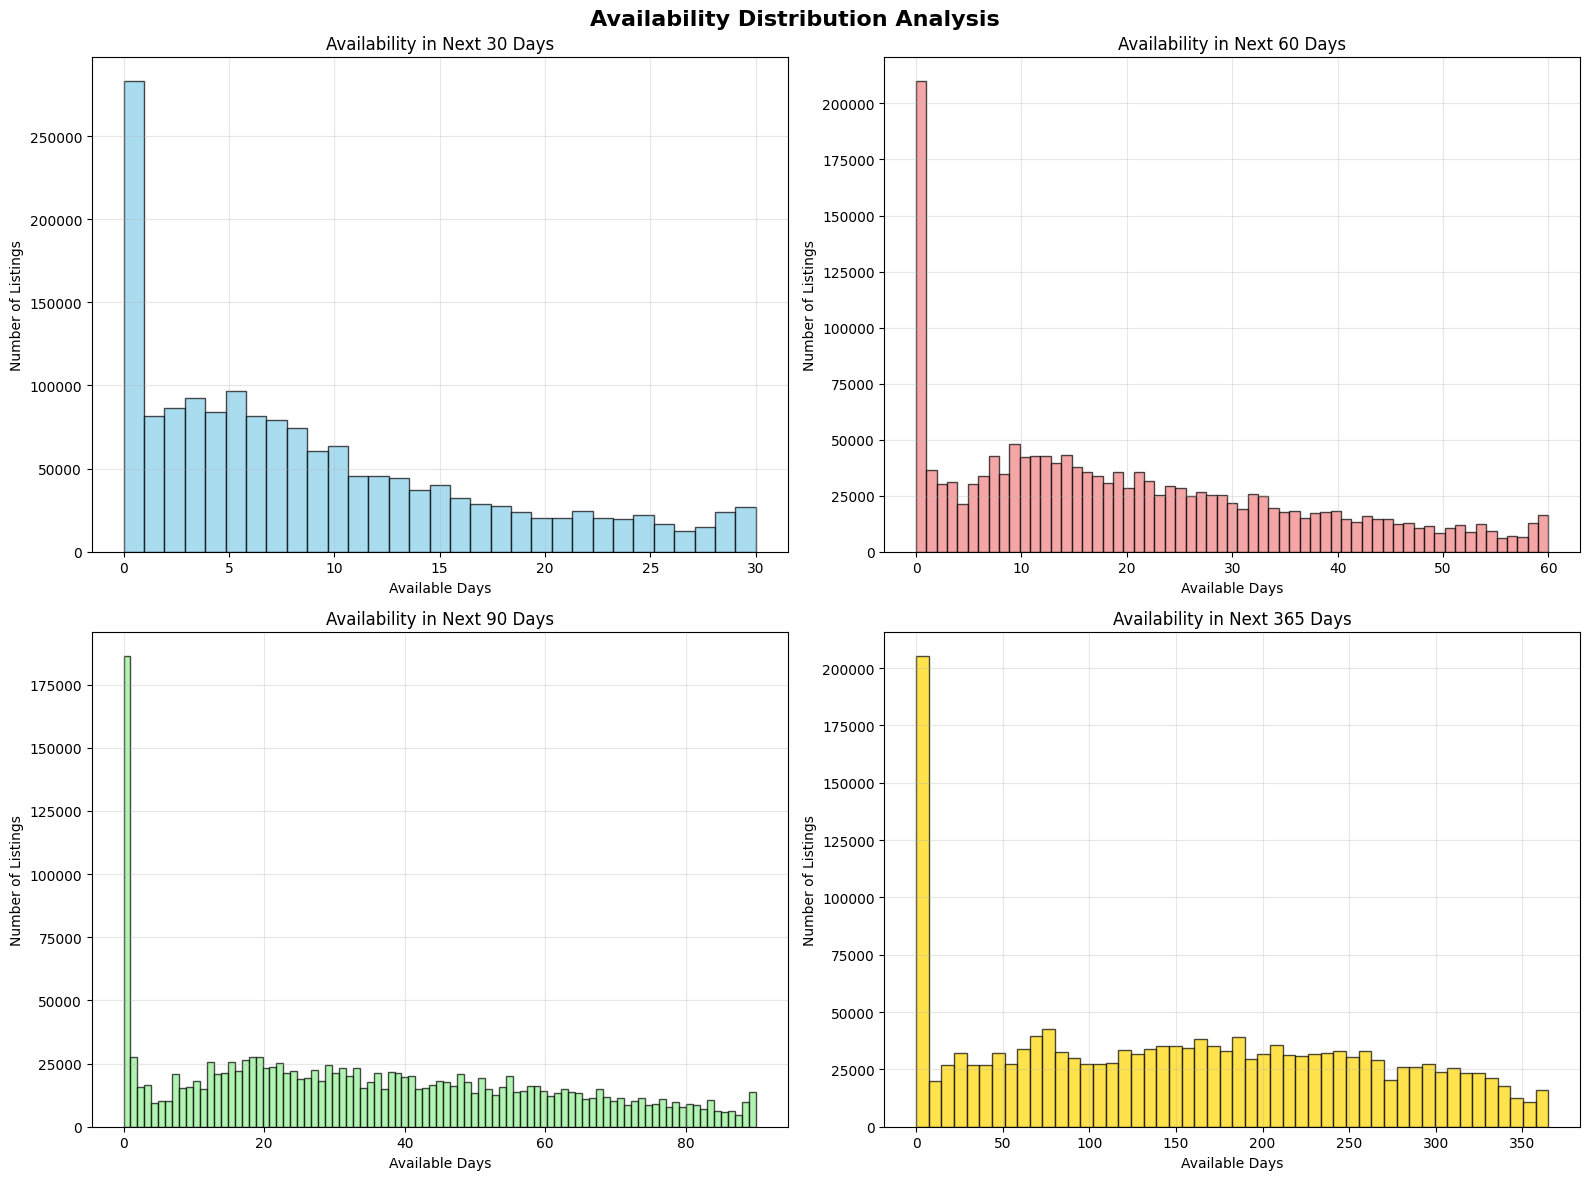

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\4151860070.py:45: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(availability_data, labels=['30 Days', '60 Days', '90 Days', '365 Days'])


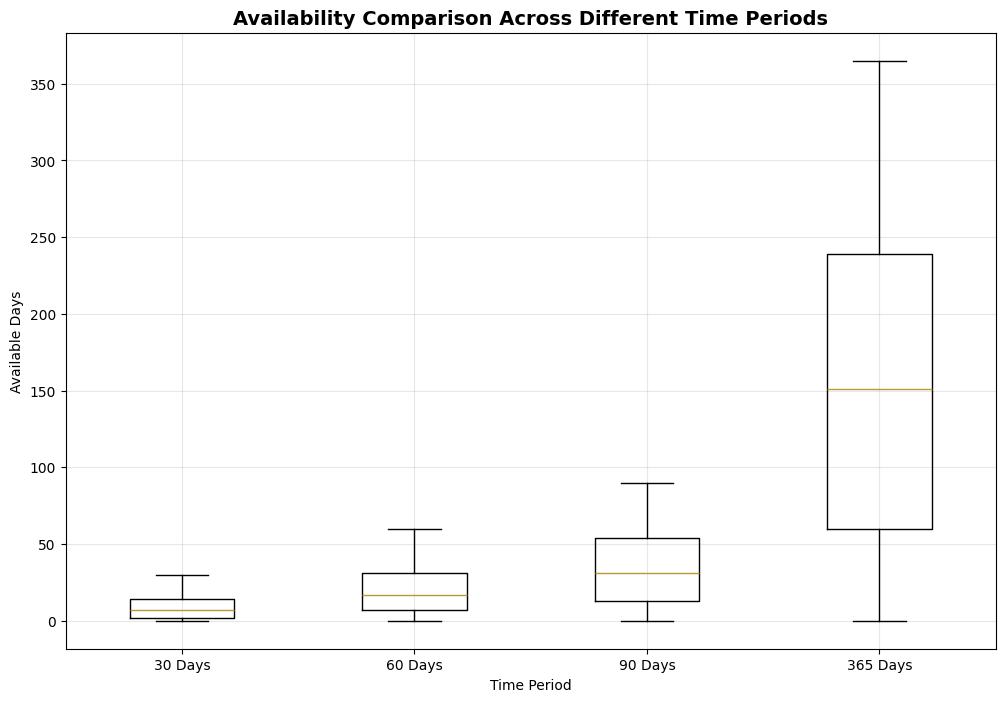

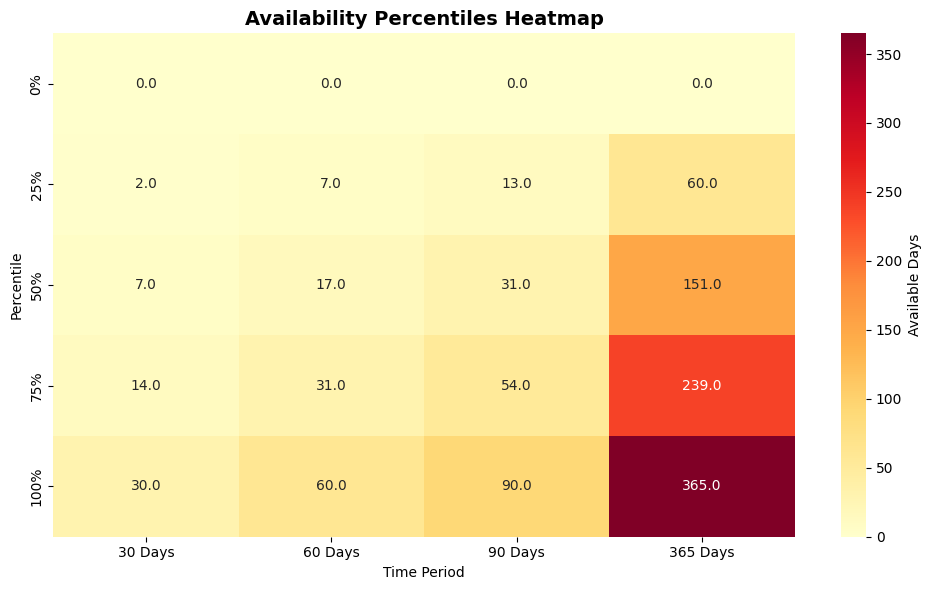

=== AVAILABILITY STATISTICS SUMMARY ===

30 DAYS AVAILABILITY:
  Mean: 8.84 days
  Median: 7.00 days
  Min: 0 days
  Max: 30 days
  Standard Deviation: 8.27 days
  Fully available (30 days): 26,917 (1.7%)
  Fully booked (0 days): 283,209 (17.4%)

60 DAYS AVAILABILITY:
  Mean: 20.18 days
  Median: 17.00 days
  Min: 0 days
  Max: 60 days
  Standard Deviation: 16.38 days
  Fully available (60 days): 16,421 (1.0%)
  Fully booked (0 days): 210,074 (12.9%)

90 DAYS AVAILABILITY:
  Mean: 34.42 days
  Median: 31.00 days
  Min: 0 days
  Max: 90 days
  Standard Deviation: 25.43 days
  Fully available (90 days): 13,625 (0.8%)
  Fully booked (0 days): 186,388 (11.4%)

365 DAYS AVAILABILITY:
  Mean: 152.40 days
  Median: 151.00 days
  Min: 0 days
  Max: 365 days
  Standard Deviation: 106.03 days
  Fully available (365 days): 4,176 (0.3%)
  Fully booked (0 days): 157,157 (9.6%)

CORRELATION BETWEEN AVAILABILITY PERIODS:
                  availability_30  availability_60  availability_90  \
availabil

In [5]:
# Create visualizations for availability metrics (30, 60, 90, 365 days)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Availability Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Availability 30 days
axes[0, 0].hist(df_listings['availability_30'], bins=31, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Availability in Next 30 Days')
axes[0, 0].set_xlabel('Available Days')
axes[0, 0].set_ylabel('Number of Listings')
axes[0, 0].grid(True, alpha=0.3)

# 2. Availability 60 days
axes[0, 1].hist(df_listings['availability_60'], bins=61, color='lightcoral', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Availability in Next 60 Days')
axes[0, 1].set_xlabel('Available Days')
axes[0, 1].set_ylabel('Number of Listings')
axes[0, 1].grid(True, alpha=0.3)

# 3. Availability 90 days
axes[1, 0].hist(df_listings['availability_90'], bins=91, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Availability in Next 90 Days')
axes[1, 0].set_xlabel('Available Days')
axes[1, 0].set_ylabel('Number of Listings')
axes[1, 0].grid(True, alpha=0.3)

# 4. Availability 365 days
axes[1, 1].hist(df_listings['availability_365'], bins=50, color='gold', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Availability in Next 365 Days')
axes[1, 1].set_xlabel('Available Days')
axes[1, 1].set_ylabel('Number of Listings')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a comparison box plot for all availability periods
plt.figure(figsize=(12, 8))
availability_data = [
    df_listings['availability_30'],
    df_listings['availability_60'],
    df_listings['availability_90'],
    df_listings['availability_365']
]

plt.boxplot(availability_data, labels=['30 Days', '60 Days', '90 Days', '365 Days'])
plt.title('Availability Comparison Across Different Time Periods', fontsize=14, fontweight='bold')
plt.xlabel('Time Period')
plt.ylabel('Available Days')
plt.grid(True, alpha=0.3)
plt.show()

# Create a heatmap showing availability distribution by percentiles
plt.figure(figsize=(10, 6))
availability_percentiles = pd.DataFrame({
    'Period': ['30 Days', '60 Days', '90 Days', '365 Days'],
    '0%': [df_listings['availability_30'].min(), df_listings['availability_60'].min(), 
           df_listings['availability_90'].min(), df_listings['availability_365'].min()],
    '25%': [df_listings['availability_30'].quantile(0.25), df_listings['availability_60'].quantile(0.25),
            df_listings['availability_90'].quantile(0.25), df_listings['availability_365'].quantile(0.25)],
    '50%': [df_listings['availability_30'].median(), df_listings['availability_60'].median(),
            df_listings['availability_90'].median(), df_listings['availability_365'].median()],
    '75%': [df_listings['availability_30'].quantile(0.75), df_listings['availability_60'].quantile(0.75),
            df_listings['availability_90'].quantile(0.75), df_listings['availability_365'].quantile(0.75)],
    '100%': [df_listings['availability_30'].max(), df_listings['availability_60'].max(),
             df_listings['availability_90'].max(), df_listings['availability_365'].max()]
})

availability_percentiles_matrix = availability_percentiles.set_index('Period').T
sns.heatmap(availability_percentiles_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Available Days'})
plt.title('Availability Percentiles Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Time Period')
plt.ylabel('Percentile')
plt.tight_layout()
plt.show()

# Print detailed statistics for each availability period
print("=== AVAILABILITY STATISTICS SUMMARY ===\n")

for period in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    days = period.split('_')[1]
    print(f"{days} DAYS AVAILABILITY:")
    print(f"  Mean: {df_listings[period].mean():.2f} days")
    print(f"  Median: {df_listings[period].median():.2f} days")
    print(f"  Min: {df_listings[period].min()} days")
    print(f"  Max: {df_listings[period].max()} days")
    print(f"  Standard Deviation: {df_listings[period].std():.2f} days")
    
    # Calculate percentage of fully available and fully booked properties
    max_days = int(days)
    fully_available = (df_listings[period] == max_days).sum()
    fully_booked = (df_listings[period] == 0).sum()
    
    print(f"  Fully available ({max_days} days): {fully_available:,} ({fully_available/len(df_listings)*100:.1f}%)")
    print(f"  Fully booked (0 days): {fully_booked:,} ({fully_booked/len(df_listings)*100:.1f}%)")
    print()

# Correlation analysis between different availability periods
print("CORRELATION BETWEEN AVAILABILITY PERIODS:")
availability_corr = df_listings[['availability_30', 'availability_60', 'availability_90', 'availability_365']].corr()
print(availability_corr.round(3))

In [ ]:
calcular Tasa de ocupación en Malaga

Total listings in Málaga: 771,561

=== TASA DE OCUPACIÓN EN MÁLAGA ===

Tasa de ocupación promedio (30 días): 75.67%
  - Días disponibles promedio: 7.3
  - Días ocupados promedio: 22.7
  - Propiedades completamente ocupadas: 153,687 (19.9%)
  - Propiedades completamente disponibles: 4,859 (0.6%)

Tasa de ocupación promedio (60 días): 69.35%
  - Días disponibles promedio: 18.4
  - Días ocupados promedio: 41.6
  - Propiedades completamente ocupadas: 128,128 (16.6%)
  - Propiedades completamente disponibles: 4,271 (0.6%)

Tasa de ocupación promedio (90 días): 63.77%
  - Días disponibles promedio: 32.6
  - Días ocupados promedio: 57.4
  - Propiedades completamente ocupadas: 121,063 (15.7%)
  - Propiedades completamente disponibles: 4,134 (0.5%)

Tasa de ocupación promedio (365 días): 60.15%
  - Días disponibles promedio: 145.5
  - Días ocupados promedio: 219.5
  - Propiedades completamente ocupadas: 109,078 (14.1%)
  - Propiedades completamente disponibles: 1,946 (0.3%)



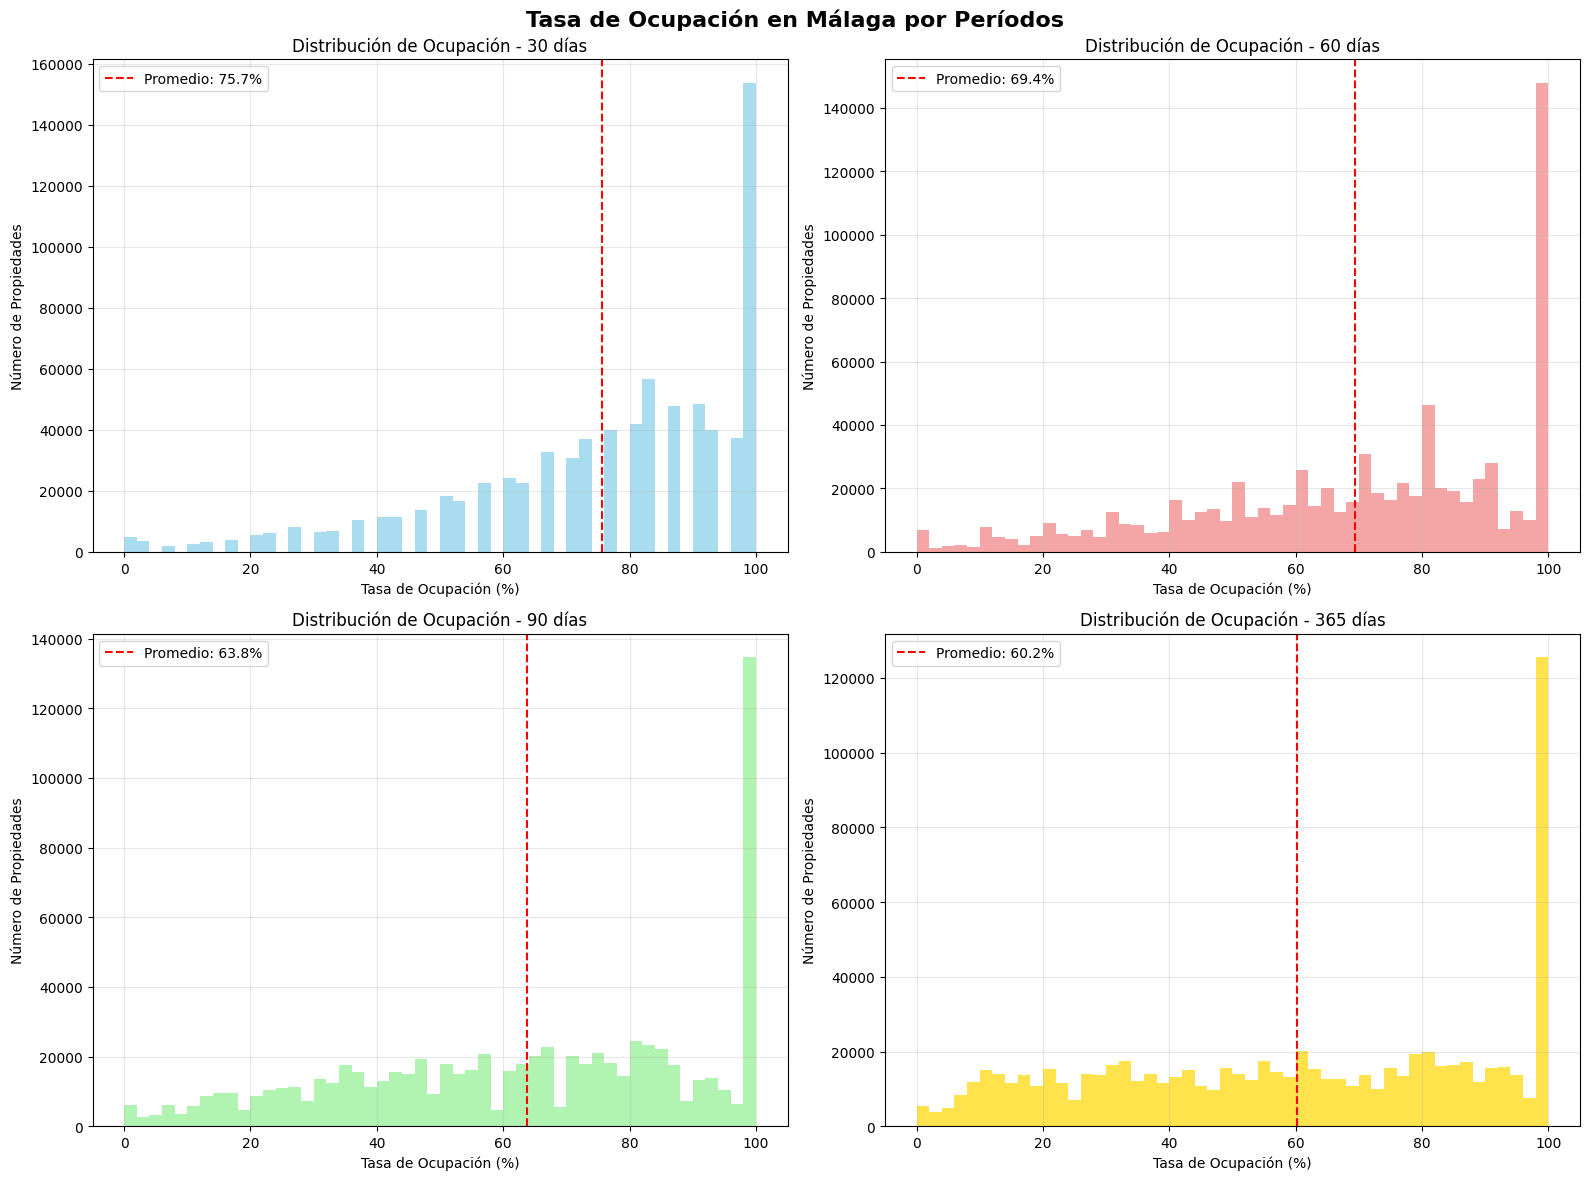


=== COMPARACIÓN MÁLAGA vs TOTAL ===

Ocupación 30 días:
  - Málaga: 75.67%
  - Total dataset: 70.52%
  - Diferencia: +5.15%

Ocupación 60 días:
  - Málaga: 69.35%
  - Total dataset: 66.37%
  - Diferencia: +2.98%

Ocupación 90 días:
  - Málaga: 63.77%
  - Total dataset: 61.76%
  - Diferencia: +2.02%

Ocupación 365 días:
  - Málaga: 60.15%
  - Total dataset: 58.25%
  - Diferencia: +1.90%



In [6]:
# Filter data for Málaga
malaga_listings = df_listings[df_listings['origen'] == 'Málaga']

print(f"Total listings in Málaga: {len(malaga_listings):,}")

# Calculate occupancy rate for different periods
print("\n=== TASA DE OCUPACIÓN EN MÁLAGA ===\n")

for period in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    days = int(period.split('_')[1])
    
    # Calculate occupancy rate: (max_days - available_days) / max_days * 100
    malaga_availability = malaga_listings[period]
    occupied_days = days - malaga_availability
    occupancy_rate = (occupied_days / days * 100).mean()
    
    print(f"Tasa de ocupación promedio ({days} días): {occupancy_rate:.2f}%")
    print(f"  - Días disponibles promedio: {malaga_availability.mean():.1f}")
    print(f"  - Días ocupados promedio: {occupied_days.mean():.1f}")
    
    # Distribution of occupancy rates
    fully_occupied = (malaga_availability == 0).sum()
    fully_available = (malaga_availability == days).sum()
    
    print(f"  - Propiedades completamente ocupadas: {fully_occupied:,} ({fully_occupied/len(malaga_listings)*100:.1f}%)")
    print(f"  - Propiedades completamente disponibles: {fully_available:,} ({fully_available/len(malaga_listings)*100:.1f}%)")
    print()

# Create visualization of occupancy rates in Málaga
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Tasa de Ocupación en Málaga por Períodos', fontsize=16, fontweight='bold')

periods = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
titles = ['30 días', '60 días', '90 días', '365 días']

for i, (period, title) in enumerate(zip(periods, titles)):
    row, col = i // 2, i % 2
    days = int(period.split('_')[1])
    
    # Calculate occupancy percentage for each listing
    availability = malaga_listings[period]
    occupancy_percentage = ((days - availability) / days * 100)
    
    axes[row, col].hist(occupancy_percentage, bins=50, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][i])
    axes[row, col].set_title(f'Distribución de Ocupación - {title}')
    axes[row, col].set_xlabel('Tasa de Ocupación (%)')
    axes[row, col].set_ylabel('Número de Propiedades')
    axes[row, col].axvline(occupancy_percentage.mean(), color='red', linestyle='--', 
                          label=f'Promedio: {occupancy_percentage.mean():.1f}%')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare Málaga with overall dataset
print("\n=== COMPARACIÓN MÁLAGA vs TOTAL ===\n")

for period in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    days = int(period.split('_')[1])
    
    # Málaga occupancy
    malaga_occupancy = ((days - malaga_listings[period]) / days * 100).mean()
    
    # Overall occupancy
    overall_occupancy = ((days - df_listings[period]) / days * 100).mean()
    
    print(f"Ocupación {days} días:")
    print(f"  - Málaga: {malaga_occupancy:.2f}%")
    print(f"  - Total dataset: {overall_occupancy:.2f}%")
    print(f"  - Diferencia: {malaga_occupancy - overall_occupancy:+.2f}%")
    print()

In [ ]:
RevPAR

=== CÁLCULO RevPAR MÁLAGA ===

Número de propiedades únicas en Málaga: 7,733

--- PERÍODO: 30 DÍAS ---
ADR (Tarifa Diaria Promedio): €206.99
Tasa de Ocupación: 70.6%
RevPAR: €146.07
RevPAR (método alternativo): €118.10
Ingresos totales estimados: €27,398,395
Noches-habitación disponibles: 231,990

--- PERÍODO: 60 DÍAS ---
ADR (Tarifa Diaria Promedio): €206.99
Tasa de Ocupación: 64.4%
RevPAR: €133.39
RevPAR (método alternativo): €109.77
Ingresos totales estimados: €50,931,527
Noches-habitación disponibles: 463,980

--- PERÍODO: 90 DÍAS ---
ADR (Tarifa Diaria Promedio): €206.99
Tasa de Ocupación: 59.3%
RevPAR: €122.76
RevPAR (método alternativo): €103.40
Ingresos totales estimados: €71,960,774
Noches-habitación disponibles: 695,970

--- PERÍODO: 365 DÍAS ---
ADR (Tarifa Diaria Promedio): €206.99
Tasa de Ocupación: 54.4%
RevPAR: €112.51
RevPAR (método alternativo): €91.29
Ingresos totales estimados: €257,662,022
Noches-habitación disponibles: 2,822,545

=== COMPARACIÓN RevPAR: MÁLAGA vs T

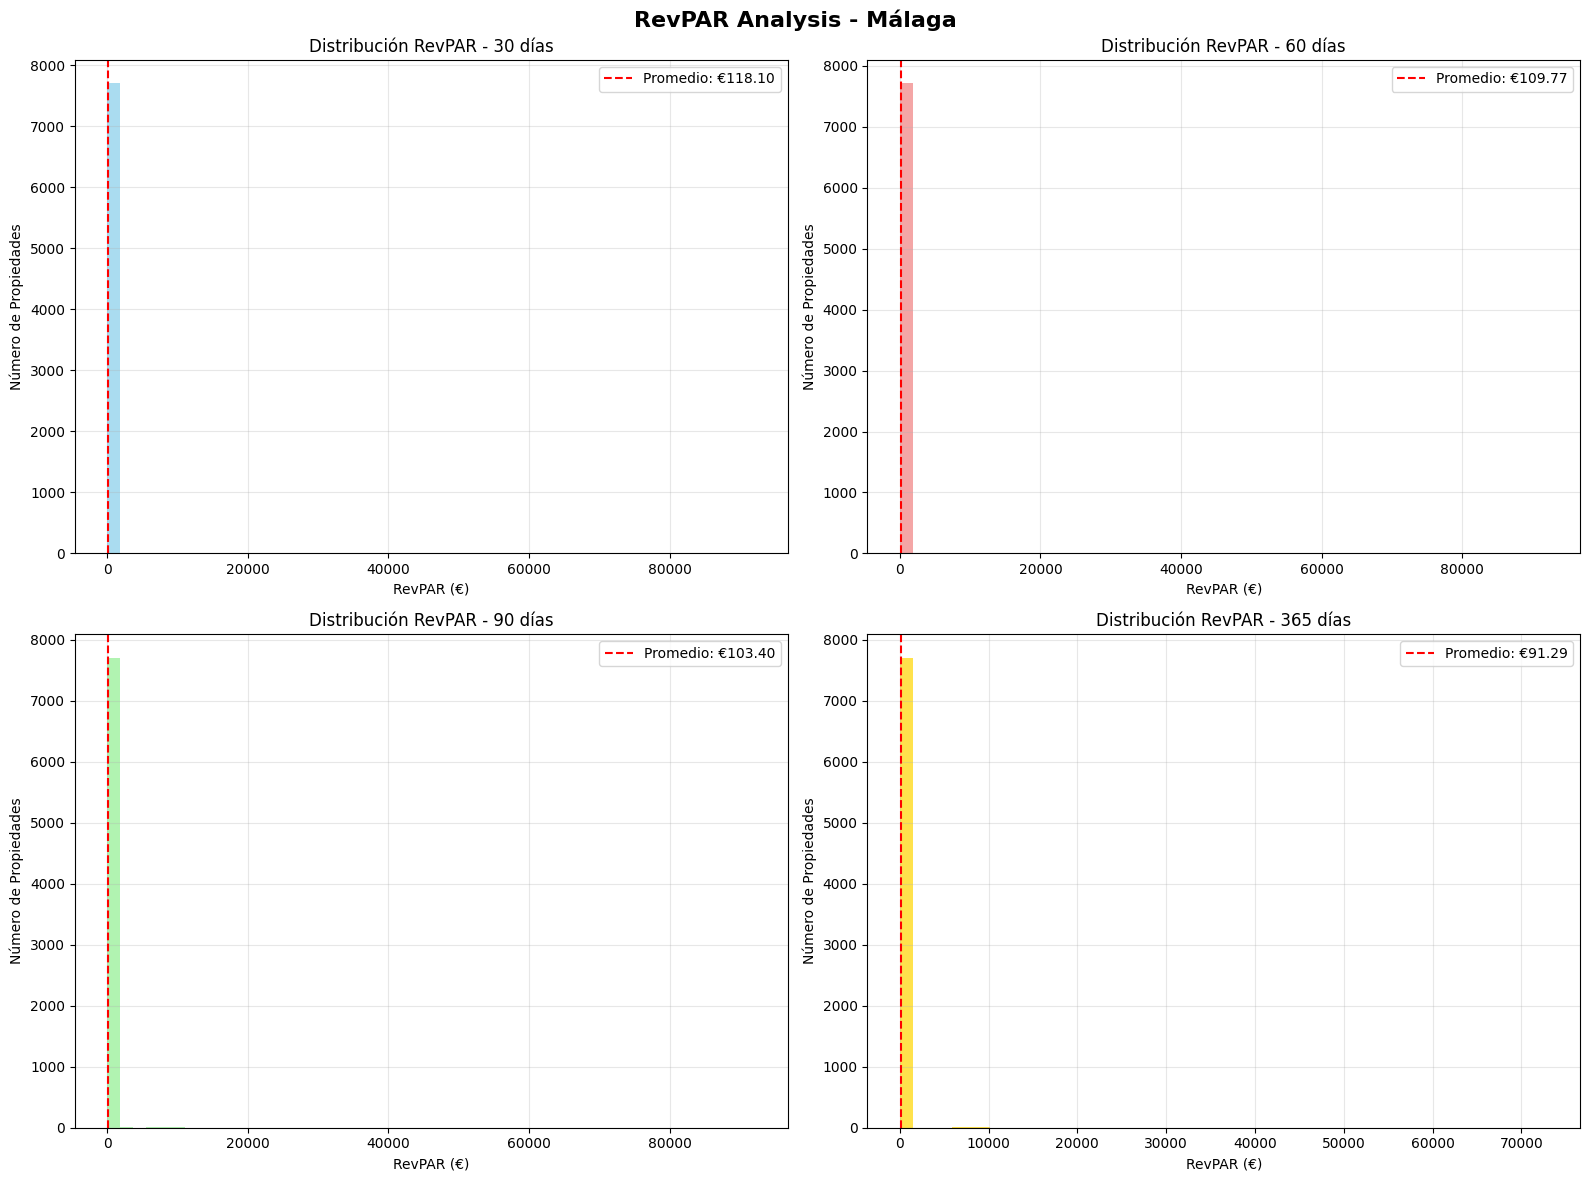

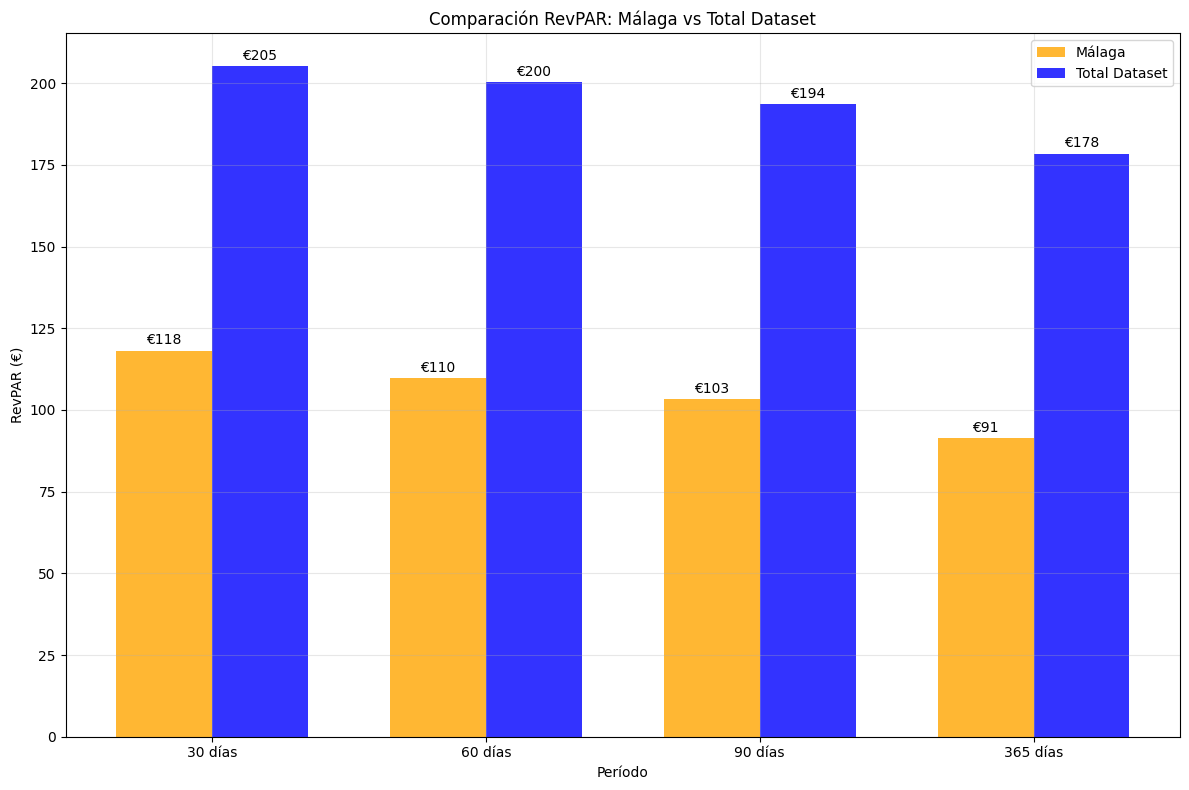

In [7]:
# Calcular RevPAR para Málaga
print("=== CÁLCULO RevPAR MÁLAGA ===\n")

# Datos base para Málaga
unique_malaga_listings = malaga_listings['id_y'].nunique()
print(f"Número de propiedades únicas en Málaga: {unique_malaga_listings:,}")

# Calcular RevPAR para diferentes períodos
for period in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    days = int(period.split('_')[1])
    
    # Calcular métricas por propiedad única
    malaga_unique = malaga_listings.groupby('id_y').agg({
        'price': 'first',
        period: 'first'
    }).reset_index()
    
    # Calcular ocupación promedio
    occupied_days = days - malaga_unique[period]
    occupancy_rate = (occupied_days / days).mean()
    
    # ADR (Average Daily Rate) - precio promedio por noche
    adr = malaga_unique['price'].mean()
    
    # RevPAR = ADR × Tasa de Ocupación
    revpar = adr * occupancy_rate
    
    # Ingresos totales estimados
    total_revenue = (malaga_unique['price'] * occupied_days).sum()
    total_available_room_nights = unique_malaga_listings * days
    revpar_alternative = total_revenue / total_available_room_nights
    
    print(f"\n--- PERÍODO: {days} DÍAS ---")
    print(f"ADR (Tarifa Diaria Promedio): €{adr:.2f}")
    print(f"Tasa de Ocupación: {occupancy_rate:.1%}")
    print(f"RevPAR: €{revpar:.2f}")
    print(f"RevPAR (método alternativo): €{revpar_alternative:.2f}")
    print(f"Ingresos totales estimados: €{total_revenue:,.0f}")
    print(f"Noches-habitación disponibles: {total_available_room_nights:,}")

# Comparar RevPAR de Málaga con el total del dataset
print("\n=== COMPARACIÓN RevPAR: MÁLAGA vs TOTAL ===\n")

for period in ['availability_30', 'availability_60', 'availability_90', 'availability_365']:
    days = int(period.split('_')[1])
    
    # RevPAR Málaga
    malaga_unique = malaga_listings.groupby('id_y').agg({
        'price': 'first',
        period: 'first'
    }).reset_index()
    
    malaga_occupancy = ((days - malaga_unique[period]) / days).mean()
    malaga_adr = malaga_unique['price'].mean()
    malaga_revpar = malaga_adr * malaga_occupancy
    
    # RevPAR Total
    total_unique = df_listings.groupby('id_y').agg({
        'price': 'first',
        period: 'first'
    }).reset_index()
    
    total_occupancy = ((days - total_unique[period]) / days).mean()
    total_adr = total_unique['price'].mean()
    total_revpar = total_adr * total_occupancy
    
    print(f"RevPAR {days} días:")
    print(f"  Málaga: €{malaga_revpar:.2f} (ADR: €{malaga_adr:.2f}, Ocupación: {malaga_occupancy:.1%})")
    print(f"  Total:  €{total_revpar:.2f} (ADR: €{total_adr:.2f}, Ocupación: {total_occupancy:.1%})")
    print(f"  Diferencia: €{malaga_revpar - total_revpar:+.2f} ({((malaga_revpar/total_revpar-1)*100):+.1f}%)")
    print()

# Crear visualización del RevPAR
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('RevPAR Analysis - Málaga', fontsize=16, fontweight='bold')

periods = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
titles = ['30 días', '60 días', '90 días', '365 días']

malaga_revpars = []
total_revpars = []

for i, (period, title) in enumerate(zip(periods, titles)):
    row, col = i // 2, i % 2
    days = int(period.split('_')[1])
    
    # Calcular RevPAR por propiedad para histograma
    malaga_unique = malaga_listings.groupby('id_y').agg({
        'price': 'first',
        period: 'first'
    }).reset_index()
    
    occupied_days = days - malaga_unique[period]
    occupancy_rate_per_property = occupied_days / days
    revpar_per_property = malaga_unique['price'] * occupancy_rate_per_property
    
    # Histograma de RevPAR
    axes[row, col].hist(revpar_per_property, bins=50, alpha=0.7, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][i])
    axes[row, col].set_title(f'Distribución RevPAR - {title}')
    axes[row, col].set_xlabel('RevPAR (€)')
    axes[row, col].set_ylabel('Número de Propiedades')
    axes[row, col].axvline(revpar_per_property.mean(), color='red', linestyle='--', 
                          label=f'Promedio: €{revpar_per_property.mean():.2f}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)
    
    # Guardar para comparación
    malaga_revpars.append(revpar_per_property.mean())
    
    # Total RevPAR
    total_unique = df_listings.groupby('id_y').agg({
        'price': 'first',
        period: 'first'
    }).reset_index()
    total_occupied = days - total_unique[period]
    total_occupancy_rate = total_occupied / days
    total_revpar_per_property = total_unique['price'] * total_occupancy_rate
    total_revpars.append(total_revpar_per_property.mean())

plt.tight_layout()
plt.show()

# Gráfico de comparación RevPAR
plt.figure(figsize=(12, 8))
x = ['30 días', '60 días', '90 días', '365 días']
width = 0.35

plt.bar([i - width/2 for i in range(len(x))], malaga_revpars, width, label='Málaga', alpha=0.8, color='orange')
plt.bar([i + width/2 for i in range(len(x))], total_revpars, width, label='Total Dataset', alpha=0.8, color='blue')

plt.xlabel('Período')
plt.ylabel('RevPAR (€)')
plt.title('Comparación RevPAR: Málaga vs Total Dataset')
plt.xticks(range(len(x)), x)
plt.legend()
plt.grid(True, alpha=0.3)

# Añadir valores en las barras
for i, (m, t) in enumerate(zip(malaga_revpars, total_revpars)):
    plt.text(i - width/2, m + 1, f'€{m:.0f}', ha='center', va='bottom')
    plt.text(i + width/2, t + 1, f'€{t:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Calcular performance de hosts en malaga

=== ANÁLISIS DE PERFORMANCE DE HOSTS EN MÁLAGA ===

Número total de hosts únicos en Málaga: 2,945
Hosts que son superhosts: 1,095
Porcentaje de superhosts: 37.2%

--- DISTRIBUCIÓN POR NÚMERO DE PROPIEDADES ---
num_properties
1     1966
2      445
3      190
4       85
5       49
6       41
7       34
8       24
9        9
10      11
Name: count, dtype: int64

--- TOP 10 HOSTS POR INGRESOS TOTALES ---
Remy: €433,026,870 (131 propiedades, 34.5% ocupación)
Andrea: €370,400,526 (47 propiedades, 69.3% ocupación)
Antonio.: €300,025,698 (64 propiedades, 80.7% ocupación)
Rocío: €223,671,258 (46 propiedades, 61.0% ocupación)
David: €197,186,136 (41 propiedades, 27.2% ocupación)
Living4Malaga: €125,062,764 (105 propiedades, 38.6% ocupación)
I Loft Malaga: €119,449,752 (204 propiedades, 40.1% ocupación)
Mima: €115,858,230 (12 propiedades, 48.8% ocupación)
Ana: €101,381,256 (64 propiedades, 35.8% ocupación)
Carolina: €83,787,834 (39 propiedades, 35.7% ocupación)

--- TOP 10 HOSTS POR RevPAR ---
Jo

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\2934349417.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(revpar_data, labels=['Superhosts', 'Regulares'])
C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\2934349417.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(occupancy_data, labels=['Superhosts', 'Regulares'])


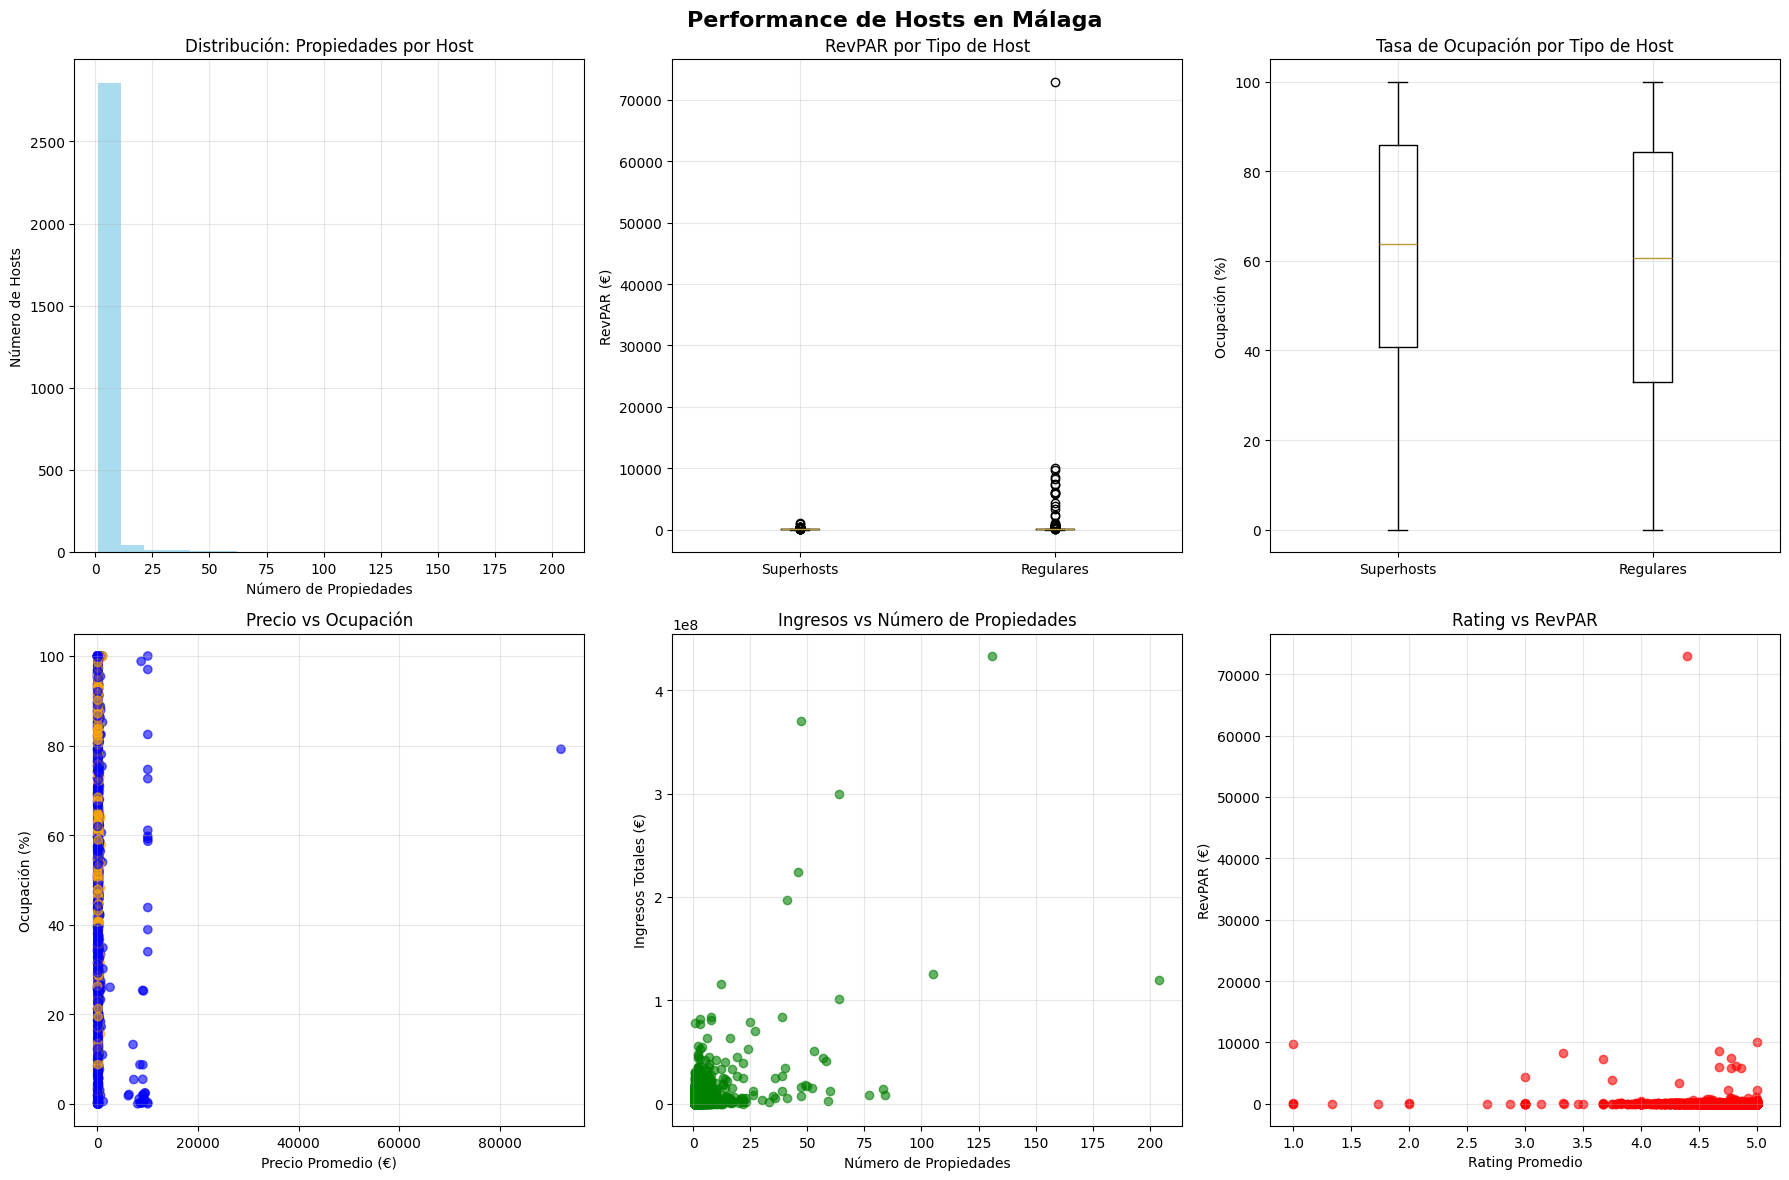


--- ANÁLISIS POR SEGMENTOS DE HOSTS ---
                          Num_Hosts  Total_Properties  Avg_Price  \
segment                                                            
Mono-host (1 prop.)            1966              1966     258.70   
Multi-host grande (11+)          91              2855     115.13   
Multi-host medio (6-10)         119               867     177.31   
Multi-host pequeño (2-5)        769              2045     293.40   

                          Avg_Occupancy  Avg_RevPAR  Total_Revenue  Avg_Rating  
segment                                                                         
Mono-host (1 prop.)               60.98      144.01   4.085291e+09        4.76  
Multi-host grande (11+)           51.25       58.01   3.236520e+09        4.58  
Multi-host medio (6-10)           56.15       74.91   1.194918e+09        4.67  
Multi-host pequeño (2-5)          57.80       89.62   3.938111e+09        4.72  


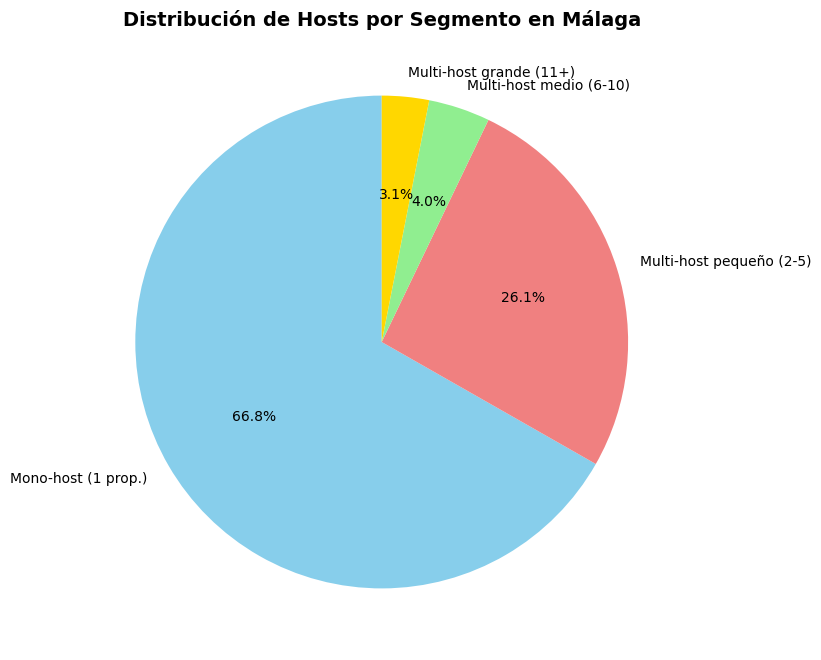


=== RESUMEN EJECUTIVO ===
- Total de hosts activos: 2,945
- Ingresos totales del mercado: €12,454,840,696
- RevPAR promedio del mercado: €124.35
- Ocupación promedio del mercado: 59.7%
- Rating promedio del mercado: 4.74


In [8]:
# Calcular performance de hosts en Málaga
print("=== ANÁLISIS DE PERFORMANCE DE HOSTS EN MÁLAGA ===\n")

# Agrupar por host para obtener métricas por anfitrión
host_performance = malaga_listings.groupby('host_id').agg({
    'id_y': 'nunique',  # Número de propiedades únicas
    'price': 'mean',    # Precio promedio
    'availability_30': 'mean',
    'availability_60': 'mean', 
    'availability_90': 'mean',
    'availability_365': 'mean',
    'number_of_reviews': 'sum',  # Total de reseñas
    'review_scores_rating': 'mean',  # Puntuación promedio
    'estimated_revenue_l365d': 'sum',  # Ingresos totales estimados
    'host_is_superhost': 'first',
    'host_name': 'first',
    'host_since': 'first'
}).reset_index()

# Renombrar columnas para claridad
host_performance.columns = ['host_id', 'num_properties', 'avg_price', 'avg_availability_30', 
                           'avg_availability_60', 'avg_availability_90', 'avg_availability_365',
                           'total_reviews', 'avg_rating', 'total_revenue', 'is_superhost', 
                           'host_name', 'host_since']

# Calcular métricas adicionales
host_performance['occupancy_rate_365'] = ((365 - host_performance['avg_availability_365']) / 365 * 100)
host_performance['revpar_365'] = host_performance['avg_price'] * (host_performance['occupancy_rate_365'] / 100)
host_performance['revenue_per_property'] = host_performance['total_revenue'] / host_performance['num_properties']

print(f"Número total de hosts únicos en Málaga: {len(host_performance):,}")
print(f"Hosts que son superhosts: {(host_performance['is_superhost'] == 't').sum():,}")
print(f"Porcentaje de superhosts: {(host_performance['is_superhost'] == 't').sum() / len(host_performance) * 100:.1f}%")

# Estadísticas por número de propiedades
print("\n--- DISTRIBUCIÓN POR NÚMERO DE PROPIEDADES ---")
property_distribution = host_performance['num_properties'].value_counts().sort_index()
print(property_distribution.head(10))

# Top 10 hosts por ingresos totales
print("\n--- TOP 10 HOSTS POR INGRESOS TOTALES ---")
top_revenue_hosts = host_performance.nlargest(10, 'total_revenue')[
    ['host_name', 'num_properties', 'total_revenue', 'avg_price', 'occupancy_rate_365', 'avg_rating', 'is_superhost']
]
for idx, host in top_revenue_hosts.iterrows():
    print(f"{host['host_name']}: €{host['total_revenue']:,.0f} ({host['num_properties']} propiedades, {host['occupancy_rate_365']:.1f}% ocupación)")

# Top 10 hosts por RevPAR
print("\n--- TOP 10 HOSTS POR RevPAR ---")
top_revpar_hosts = host_performance.nlargest(10, 'revpar_365')[
    ['host_name', 'num_properties', 'revpar_365', 'avg_price', 'occupancy_rate_365', 'avg_rating', 'is_superhost']
]
for idx, host in top_revpar_hosts.iterrows():
    print(f"{host['host_name']}: €{host['revpar_365']:.2f} RevPAR (€{host['avg_price']:.0f} ADR, {host['occupancy_rate_365']:.1f}% ocupación)")

# Comparación Superhosts vs No-Superhosts
print("\n--- COMPARACIÓN: SUPERHOSTS vs NO-SUPERHOSTS ---")
superhosts = host_performance[host_performance['is_superhost'] == 't']
regular_hosts = host_performance[host_performance['is_superhost'] == 'f']

print(f"SUPERHOSTS ({len(superhosts)} hosts):")
print(f"  - Precio promedio: €{superhosts['avg_price'].mean():.2f}")
print(f"  - Ocupación promedio: {superhosts['occupancy_rate_365'].mean():.1f}%")
print(f"  - RevPAR promedio: €{superhosts['revpar_365'].mean():.2f}")
print(f"  - Rating promedio: {superhosts['avg_rating'].mean():.2f}")
print(f"  - Propiedades promedio por host: {superhosts['num_properties'].mean():.1f}")
print(f"  - Ingresos promedio por host: €{superhosts['total_revenue'].mean():.0f}")

print(f"\nHOSTS REGULARES ({len(regular_hosts)} hosts):")
print(f"  - Precio promedio: €{regular_hosts['avg_price'].mean():.2f}")
print(f"  - Ocupación promedio: {regular_hosts['occupancy_rate_365'].mean():.1f}%")
print(f"  - RevPAR promedio: €{regular_hosts['revpar_365'].mean():.2f}")
print(f"  - Rating promedio: {regular_hosts['avg_rating'].mean():.2f}")
print(f"  - Propiedades promedio por host: {regular_hosts['num_properties'].mean():.1f}")
print(f"  - Ingresos promedio por host: €{regular_hosts['total_revenue'].mean():.0f}")

# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Performance de Hosts en Málaga', fontsize=16, fontweight='bold')

# 1. Distribución de número de propiedades por host
axes[0, 0].hist(host_performance['num_properties'], bins=20, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Distribución: Propiedades por Host')
axes[0, 0].set_xlabel('Número de Propiedades')
axes[0, 0].set_ylabel('Número de Hosts')
axes[0, 0].grid(True, alpha=0.3)

# 2. RevPAR por tipo de host
revpar_data = [superhosts['revpar_365'].dropna(), regular_hosts['revpar_365'].dropna()]
axes[0, 1].boxplot(revpar_data, labels=['Superhosts', 'Regulares'])
axes[0, 1].set_title('RevPAR por Tipo de Host')
axes[0, 1].set_ylabel('RevPAR (€)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Ocupación por tipo de host
occupancy_data = [superhosts['occupancy_rate_365'].dropna(), regular_hosts['occupancy_rate_365'].dropna()]
axes[0, 2].boxplot(occupancy_data, labels=['Superhosts', 'Regulares'])
axes[0, 2].set_title('Tasa de Ocupación por Tipo de Host')
axes[0, 2].set_ylabel('Ocupación (%)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter: Precio vs Ocupación
axes[1, 0].scatter(host_performance['avg_price'], host_performance['occupancy_rate_365'], 
                   c=['orange' if x == 't' else 'blue' for x in host_performance['is_superhost']], 
                   alpha=0.6)
axes[1, 0].set_xlabel('Precio Promedio (€)')
axes[1, 0].set_ylabel('Ocupación (%)')
axes[1, 0].set_title('Precio vs Ocupación')
axes[1, 0].grid(True, alpha=0.3)

# 5. Ingresos totales por número de propiedades
axes[1, 1].scatter(host_performance['num_properties'], host_performance['total_revenue'], alpha=0.6, color='green')
axes[1, 1].set_xlabel('Número de Propiedades')
axes[1, 1].set_ylabel('Ingresos Totales (€)')
axes[1, 1].set_title('Ingresos vs Número de Propiedades')
axes[1, 1].grid(True, alpha=0.3)

# 6. Rating vs RevPAR
axes[1, 2].scatter(host_performance['avg_rating'], host_performance['revpar_365'], alpha=0.6, color='red')
axes[1, 2].set_xlabel('Rating Promedio')
axes[1, 2].set_ylabel('RevPAR (€)')
axes[1, 2].set_title('Rating vs RevPAR')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis por segmentos de hosts
print("\n--- ANÁLISIS POR SEGMENTOS DE HOSTS ---")
host_performance['segment'] = host_performance['num_properties'].apply(
    lambda x: 'Mono-host (1 prop.)' if x == 1 
    else 'Multi-host pequeño (2-5)' if x <= 5 
    else 'Multi-host medio (6-10)' if x <= 10 
    else 'Multi-host grande (11+)'
)

segment_analysis = host_performance.groupby('segment').agg({
    'host_id': 'count',
    'num_properties': 'sum',
    'avg_price': 'mean',
    'occupancy_rate_365': 'mean',
    'revpar_365': 'mean',
    'total_revenue': 'sum',
    'avg_rating': 'mean'
}).round(2)

segment_analysis.columns = ['Num_Hosts', 'Total_Properties', 'Avg_Price', 'Avg_Occupancy', 
                           'Avg_RevPAR', 'Total_Revenue', 'Avg_Rating']

print(segment_analysis)

# Crear gráfico de distribución de segmentos
plt.figure(figsize=(12, 8))
segment_counts = host_performance['segment'].value_counts()
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']
plt.pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%', 
        colors=colors, startangle=90)
plt.title('Distribución de Hosts por Segmento en Málaga', fontsize=14, fontweight='bold')
plt.show()

print(f"\n=== RESUMEN EJECUTIVO ===")
print(f"- Total de hosts activos: {len(host_performance):,}")
print(f"- Ingresos totales del mercado: €{host_performance['total_revenue'].sum():,.0f}")
print(f"- RevPAR promedio del mercado: €{host_performance['revpar_365'].mean():.2f}")
print(f"- Ocupación promedio del mercado: {host_performance['occupancy_rate_365'].mean():.1f}%")
print(f"- Rating promedio del mercado: {host_performance['avg_rating'].mean():.2f}")


calificaciones promedio Malaga

=== ANÁLISIS DE CALIFICACIONES PROMEDIO EN MÁLAGA ===

1. CALIFICACIONES GENERALES:
Calificación promedio general: 4.74/5.00
Número total de reseñas: 131,398,315
Propiedades con calificaciones: 771,561

2. CALIFICACIONES POR CATEGORÍA:
Precisión: 4.80/5.00
Limpieza: 4.76/5.00
Check-in: 4.83/5.00
Comunicación: 4.86/5.00
Ubicación: 4.77/5.00
Relación calidad-precio: 4.69/5.00

3. COMPARACIÓN MÁLAGA vs TOTAL:
Málaga vs Total:
Calificación general: 4.74 vs 4.75
Precisión: 4.80 vs 4.80 (Diferencia: -0.00)
Limpieza: 4.76 vs 4.75 (Diferencia: +0.01)
Check-in: 4.83 vs 4.85 (Diferencia: -0.01)
Comunicación: 4.86 vs 4.86 (Diferencia: -0.00)
Ubicación: 4.77 vs 4.77 (Diferencia: +0.01)
Relación calidad-precio: 4.69 vs 4.68 (Diferencia: +0.01)

4. CALIFICACIONES POR TIPO DE PROPIEDAD (Top 5):
Entire rental unit: 4.74 (5,446 propiedades)
Private room in rental unit: 4.66 (588 propiedades)
Entire condo: 4.78 (351 propiedades)
Entire home: 4.79 (267 propiedades)
Entire serviced apartment: 4.76 (253 pr

C:\Users\Andrei.Baidurov\AppData\Local\Temp\ipykernel_4028\1587701845.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(rating_data, labels=['Superhosts', 'Regulares'])


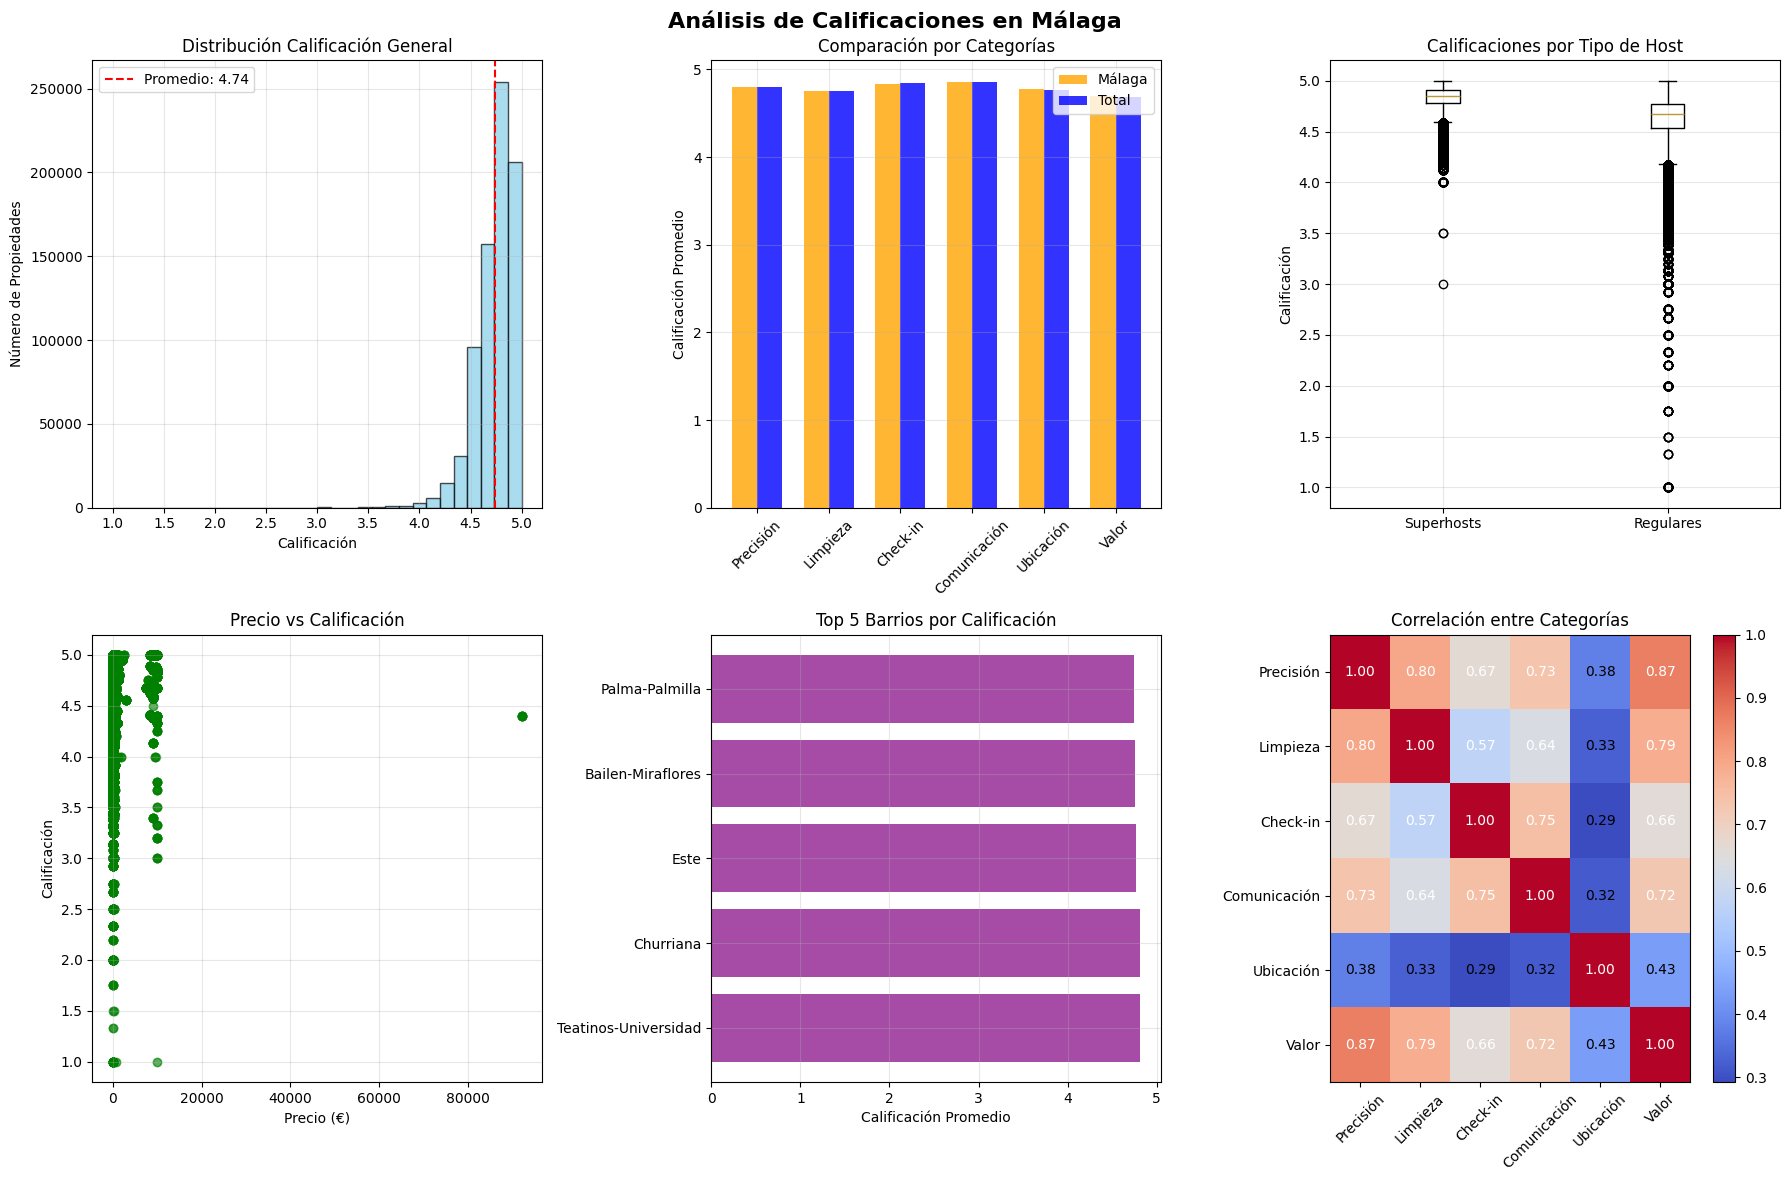


7. PROPIEDADES MEJOR CALIFICADAS (Top 5):
Casa con piscina,cerca de la  feria... - 5.00 (13 reseñas, €107)
Casa con piscina,cerca de la  feria... - 5.00 (13 reseñas, €107)
Casa con piscina,cerca de la  feria... - 5.00 (13 reseñas, €107)
Casa con piscina,cerca de la  feria... - 5.00 (13 reseñas, €107)
Casa con piscina,cerca de la  feria... - 5.00 (13 reseñas, €107)

8. ESTADÍSTICAS DE DISTRIBUCIÓN:
Calificaciones 5.0: 13,980 (1.8%)
Calificaciones 4.5+: 699,651 (90.7%)
Calificaciones 4.0+: 766,760 (99.4%)
Calificaciones <4.0: 4,801 (0.6%)

=== RESUMEN EJECUTIVO ===
- Calificación promedio: 4.74/5.00
- Mejor categoría: Comunicación (4.86)
- Categoría a mejorar: Relación calidad-precio (4.69)
- Ventaja de superhosts: +0.20 puntos


In [9]:
# Análisis de calificaciones promedio en Málaga
print("=== ANÁLISIS DE CALIFICACIONES PROMEDIO EN MÁLAGA ===\n")

# Calificaciones generales
print("1. CALIFICACIONES GENERALES:")
print(f"Calificación promedio general: {malaga_listings['review_scores_rating'].mean():.2f}/5.00")
print(f"Número total de reseñas: {malaga_listings['number_of_reviews'].sum():,}")
print(f"Propiedades con calificaciones: {malaga_listings['review_scores_rating'].notna().sum():,}")

# Distribución de calificaciones específicas
print("\n2. CALIFICACIONES POR CATEGORÍA:")
categories = {
    'Precisión': 'review_scores_accuracy',
    'Limpieza': 'review_scores_cleanliness', 
    'Check-in': 'review_scores_checkin',
    'Comunicación': 'review_scores_communication',
    'Ubicación': 'review_scores_location',
    'Relación calidad-precio': 'review_scores_value'
}

for category, column in categories.items():
    avg_score = malaga_listings[column].mean()
    print(f"{category}: {avg_score:.2f}/5.00")

# Comparación con dataset completo
print("\n3. COMPARACIÓN MÁLAGA vs TOTAL:")
print("Málaga vs Total:")
print(f"Calificación general: {malaga_listings['review_scores_rating'].mean():.2f} vs {df_listings['review_scores_rating'].mean():.2f}")
for category, column in categories.items():
    malaga_avg = malaga_listings[column].mean()
    total_avg = df_listings[column].mean()
    diff = malaga_avg - total_avg
    print(f"{category}: {malaga_avg:.2f} vs {total_avg:.2f} (Diferencia: {diff:+.2f})")

# Análisis por tipo de propiedad
print("\n4. CALIFICACIONES POR TIPO DE PROPIEDAD (Top 5):")
property_ratings = malaga_listings.groupby('property_type').agg({
    'review_scores_rating': 'mean',
    'id_y': 'nunique'
}).reset_index()
property_ratings.columns = ['property_type', 'avg_rating', 'count']
property_ratings = property_ratings.sort_values('count', ascending=False).head(5)

for _, row in property_ratings.iterrows():
    print(f"{row['property_type']}: {row['avg_rating']:.2f} ({row['count']:,} propiedades)")

# Análisis por barrio
print("\n5. CALIFICACIONES POR BARRIO (Top 10):")
neighbourhood_ratings = malaga_listings.groupby('neighbourhood_cleansed').agg({
    'review_scores_rating': 'mean',
    'id_y': 'nunique'
}).reset_index()
neighbourhood_ratings.columns = ['neighbourhood', 'avg_rating', 'count']
neighbourhood_ratings = neighbourhood_ratings[neighbourhood_ratings['count'] >= 50]  # Mínimo 50 propiedades
neighbourhood_ratings = neighbourhood_ratings.sort_values('avg_rating', ascending=False).head(10)

for _, row in neighbourhood_ratings.iterrows():
    print(f"{row['neighbourhood']}: {row['avg_rating']:.2f} ({row['count']:,} propiedades)")

# Superhosts vs Regular hosts
print("\n6. CALIFICACIONES: SUPERHOSTS vs HOSTS REGULARES:")
superhost_ratings = malaga_listings[malaga_listings['host_is_superhost'] == 't']['review_scores_rating'].mean()
regular_ratings = malaga_listings[malaga_listings['host_is_superhost'] == 'f']['review_scores_rating'].mean()

print(f"Superhosts: {superhost_ratings:.2f}")
print(f"Hosts regulares: {regular_ratings:.2f}")
print(f"Diferencia: {superhost_ratings - regular_ratings:+.2f}")

# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Calificaciones en Málaga', fontsize=16, fontweight='bold')

# 1. Distribución de calificación general
axes[0, 0].hist(malaga_listings['review_scores_rating'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(malaga_listings['review_scores_rating'].mean(), color='red', linestyle='--', 
                   label=f'Promedio: {malaga_listings["review_scores_rating"].mean():.2f}')
axes[0, 0].set_title('Distribución Calificación General')
axes[0, 0].set_xlabel('Calificación')
axes[0, 0].set_ylabel('Número de Propiedades')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Comparación por categorías
categories_short = ['Precisión', 'Limpieza', 'Check-in', 'Comunicación', 'Ubicación', 'Valor']
malaga_scores = [malaga_listings[col].mean() for col in categories.values()]
total_scores = [df_listings[col].mean() for col in categories.values()]

x_pos = range(len(categories_short))
width = 0.35

axes[0, 1].bar([i - width/2 for i in x_pos], malaga_scores, width, label='Málaga', alpha=0.8, color='orange')
axes[0, 1].bar([i + width/2 for i in x_pos], total_scores, width, label='Total', alpha=0.8, color='blue')
axes[0, 1].set_title('Comparación por Categorías')
axes[0, 1].set_ylabel('Calificación Promedio')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(categories_short, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot por tipo de host
rating_data = [
    malaga_listings[malaga_listings['host_is_superhost'] == 't']['review_scores_rating'].dropna(),
    malaga_listings[malaga_listings['host_is_superhost'] == 'f']['review_scores_rating'].dropna()
]
axes[0, 2].boxplot(rating_data, labels=['Superhosts', 'Regulares'])
axes[0, 2].set_title('Calificaciones por Tipo de Host')
axes[0, 2].set_ylabel('Calificación')
axes[0, 2].grid(True, alpha=0.3)

# 4. Scatter: Precio vs Calificación
axes[1, 0].scatter(malaga_listings['price'], malaga_listings['review_scores_rating'], alpha=0.4, color='green')
axes[1, 0].set_xlabel('Precio (€)')
axes[1, 0].set_ylabel('Calificación')
axes[1, 0].set_title('Precio vs Calificación')
axes[1, 0].grid(True, alpha=0.3)

# 5. Top barrios por calificación
top_neighbourhoods = neighbourhood_ratings.head(5)
axes[1, 1].barh(top_neighbourhoods['neighbourhood'], top_neighbourhoods['avg_rating'], color='purple', alpha=0.7)
axes[1, 1].set_title('Top 5 Barrios por Calificación')
axes[1, 1].set_xlabel('Calificación Promedio')
axes[1, 1].grid(True, alpha=0.3)

# 6. Correlación entre categorías
correlation_data = malaga_listings[list(categories.values())].corr()
im = axes[1, 2].imshow(correlation_data, cmap='coolwarm', aspect='auto')
axes[1, 2].set_title('Correlación entre Categorías')
axes[1, 2].set_xticks(range(len(categories_short)))
axes[1, 2].set_yticks(range(len(categories_short)))
axes[1, 2].set_xticklabels(categories_short, rotation=45)
axes[1, 2].set_yticklabels(categories_short)

# Añadir valores de correlación
for i in range(len(categories_short)):
    for j in range(len(categories_short)):
        axes[1, 2].text(j, i, f'{correlation_data.iloc[i, j]:.2f}', 
                        ha='center', va='center', color='white' if abs(correlation_data.iloc[i, j]) > 0.5 else 'black')

plt.colorbar(im, ax=axes[1, 2])
plt.tight_layout()
plt.show()

# Análisis de propiedades mejor y peor calificadas
print("\n7. PROPIEDADES MEJOR CALIFICADAS (Top 5):")
best_rated = malaga_listings.nlargest(5, 'review_scores_rating')[
    ['name', 'review_scores_rating', 'number_of_reviews', 'price', 'neighbourhood_cleansed', 'host_name']
]
for _, prop in best_rated.iterrows():
    print(f"{prop['name'][:50]}... - {prop['review_scores_rating']:.2f} ({prop['number_of_reviews']} reseñas, €{prop['price']:.0f})")

print("\n8. ESTADÍSTICAS DE DISTRIBUCIÓN:")
print(f"Calificaciones 5.0: {(malaga_listings['review_scores_rating'] == 5.0).sum():,} ({(malaga_listings['review_scores_rating'] == 5.0).sum() / len(malaga_listings) * 100:.1f}%)")
print(f"Calificaciones 4.5+: {(malaga_listings['review_scores_rating'] >= 4.5).sum():,} ({(malaga_listings['review_scores_rating'] >= 4.5).sum() / len(malaga_listings) * 100:.1f}%)")
print(f"Calificaciones 4.0+: {(malaga_listings['review_scores_rating'] >= 4.0).sum():,} ({(malaga_listings['review_scores_rating'] >= 4.0).sum() / len(malaga_listings) * 100:.1f}%)")
print(f"Calificaciones <4.0: {(malaga_listings['review_scores_rating'] < 4.0).sum():,} ({(malaga_listings['review_scores_rating'] < 4.0).sum() / len(malaga_listings) * 100:.1f}%)")

print(f"\n=== RESUMEN EJECUTIVO ===")
print(f"- Calificación promedio: {malaga_listings['review_scores_rating'].mean():.2f}/5.00")
print(f"- Mejor categoría: {max(categories.keys(), key=lambda k: malaga_listings[categories[k]].mean())} ({max(malaga_listings[col].mean() for col in categories.values()):.2f})")
print(f"- Categoría a mejorar: {min(categories.keys(), key=lambda k: malaga_listings[categories[k]].mean())} ({min(malaga_listings[col].mean() for col in categories.values()):.2f})")
print(f"- Ventaja de superhosts: +{superhost_ratings - regular_ratings:.2f} puntos")